<a href="https://colab.research.google.com/github/Hisernberg/BLEACH---Bangla-Language-Expert-Adaptive-Corpus-Handler/blob/main/BLEACH_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Sampler
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
from collections import defaultdict
from typing import Dict, List, Tuple
import json


class DataConfig:
    """Centralized configuration"""

    TRAIN_PATH = "/content/cleaned_bangla_train (1).csv"
    VAL_PATH = "/content/cleaned_bangla_val (1).csv"
    TEST_PATH = "/content/cleaned_bangla_test (2).csv"


    TOKENIZER_NAME = "sagorsarker/bangla-bert-base"
    MAX_SEQ_LEN = 512


    DIALECTS = ["chittagong", "sylhet", "barisal", "noakhali", "mymensingh"]
    DIALECT_TO_ID = {d: i for i, d in enumerate(DIALECTS)}

    BATCH_SIZE = 12
    NUM_WORKERS = 2
    PIN_MEMORY = True


    SAMPLES_PER_DIALECT = BATCH_SIZE // len(DIALECTS)
    assert BATCH_SIZE % len(DIALECTS) == 0 or BATCH_SIZE >= len(DIALECTS), \
        "Batch size should be divisible by number of dialects for perfect balancing"



class BanglaDialectDataset(Dataset):
    """
    Memory-efficient dataset with on-the-fly tokenization.
    Preserves dialect information for MoE routing.
    """

    def __init__(
        self,
        csv_path: str,
        tokenizer,
        max_length: int = 512,
        dialect_to_id: Dict[str, int] = None
    ):
        """
        Args:
            csv_path: Path to CSV with columns [text, dialect]
            tokenizer: HuggingFace tokenizer
            max_length: Max sequence length (truncation point)
            dialect_to_id: Mapping from dialect name to integer ID
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.dialect_to_id = dialect_to_id or DataConfig.DIALECT_TO_ID


        print(f"Loading dataset from {csv_path}...")
        self.data = pd.read_csv(csv_path)

        assert "text" in self.data.columns, "CSV must have 'text' column"
        assert "dialect" in self.data.columns, "CSV must have 'dialect' column"


        self.data["dialect"] = self.data["dialect"].str.lower().str.strip()
        invalid_dialects = set(self.data["dialect"]) - set(self.dialect_to_id.keys())
        if invalid_dialects:
            print(f"WARNING: Found invalid dialects: {invalid_dialects}")
            self.data = self.data[self.data["dialect"].isin(self.dialect_to_id.keys())]


        self.dialect_indices = defaultdict(list)
        for idx, dialect in enumerate(self.data["dialect"]):
            self.dialect_indices[dialect].append(idx)

        print(f"Loaded {len(self.data)} samples")
        print("Dialect distribution:")
        for dialect, indices in self.dialect_indices.items():
            print(f"  {dialect}: {len(indices)} samples")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Returns:
            input_ids: [seq_len] - tokenized text
            attention_mask: [seq_len] - 1 for real tokens, 0 for padding
            dialect_id: scalar - integer dialect ID
        """
        row = self.data.iloc[idx]
        text = str(row["text"])
        dialect = row["dialect"]

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            add_special_tokens=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "dialect_id": torch.tensor(self.dialect_to_id[dialect], dtype=torch.long)
        }

    def get_dialect_indices(self, dialect: str) -> List[int]:
        """Get all indices for a specific dialect"""
        return self.dialect_indices[dialect]



class DialectBalancedSampler(Sampler):
    """
    Samples equal numbers from each dialect per batch.
    Prevents expert collapse by ensuring all experts see data each batch.

    Strategy:
    - Each batch contains samples_per_dialect samples from EACH dialect
    - Randomly shuffles within each dialect
    - Cycles through dialects until epoch ends
    """

    def __init__(
        self,
        dataset: BanglaDialectDataset,
        samples_per_dialect: int,
        shuffle: bool = True
    ):
        """
        Args:
            dataset: BanglaDialectDataset instance
            samples_per_dialect: Number of samples per dialect per batch
            shuffle: Whether to shuffle indices within each dialect
        """
        self.dataset = dataset
        self.samples_per_dialect = samples_per_dialect
        self.shuffle = shuffle
        self.dialects = list(dataset.dialect_to_id.keys())


        min_dialect_size = min(
            len(dataset.get_dialect_indices(d)) for d in self.dialects
        )
        self.num_batches = min_dialect_size // samples_per_dialect
        self.total_samples = self.num_batches * samples_per_dialect * len(self.dialects)

        print(f"DialectBalancedSampler initialized:")
        print(f"  Samples per dialect per batch: {samples_per_dialect}")
        print(f"  Total batches per epoch: {self.num_batches}")
        print(f"  Total samples per epoch: {self.total_samples}")

    def __iter__(self):

        dialect_iterators = {}
        for dialect in self.dialects:
            indices = self.dataset.get_dialect_indices(dialect)
            if self.shuffle:
                indices = np.random.permutation(indices).tolist()
            dialect_iterators[dialect] = iter(indices)


        for _ in range(self.num_batches):
            batch_indices = []
            for dialect in self.dialects:
                # Fix: Indent this for loop correctly
                for _ in range(self.samples_per_dialect):
                    try:
                        batch_indices.append(next(dialect_iterators[dialect]))
                    except StopIteration:
                        # If a dialect runs out of samples, break from sampling for this dialect
                        break


            if self.shuffle:
                np.random.shuffle(batch_indices)

            yield from batch_indices

    def __len__(self) -> int:
        return self.total_samples




def dialect_aware_collate_fn(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    """
    Dynamic padding collate function.
    Pads to the maximum length in THIS batch (not global max_length).

    Args:
        batch: List of dicts from dataset.__getitem__

    Returns:
        input_ids: [batch_size, max_len_in_batch]
        attention_mask: [batch_size, max_len_in_batch]
        dialect_ids: [batch_size]
    """

    max_len = max(item["input_ids"].size(0) for item in batch)

    batch_size = len(batch)
    pad_token_id = 0


    input_ids = torch.full((batch_size, max_len), pad_token_id, dtype=torch.long)
    attention_mask = torch.zeros((batch_size, max_len), dtype=torch.long)
    dialect_ids = torch.zeros(batch_size, dtype=torch.long)


    for i, item in enumerate(batch):
        seq_len = item["input_ids"].size(0)
        input_ids[i, :seq_len] = item["input_ids"]
        attention_mask[i, :seq_len] = item["attention_mask"]
        dialect_ids[i] = item["dialect_id"]

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "dialect_ids": dialect_ids
    }



def build_dataloaders(
    train_path: str,
    val_path: str,
    test_path: str,
    tokenizer,
    batch_size: int = 12,
    samples_per_dialect: int = 2,
    num_workers: int = 2,
    pin_memory: bool = True
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Build train/val/test dataloaders with balanced sampling.

    Returns:
        train_loader, val_loader, test_loader
    """

    train_dataset = BanglaDialectDataset(train_path, tokenizer)
    val_dataset = BanglaDialectDataset(val_path, tokenizer)
    test_dataset = BanglaDialectDataset(test_path, tokenizer)


    train_sampler = DialectBalancedSampler(
        train_dataset,
        samples_per_dialect=samples_per_dialect,
        shuffle=True
    )


    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        collate_fn=dialect_aware_collate_fn,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=dialect_aware_collate_fn,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=dialect_aware_collate_fn,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    return train_loader, val_loader, test_loader


def setup_data_pipeline():
    """
    Complete setup: tokenizer, datasets, dataloaders.
    Run this function to initialize everything.
    """
    print("="*80)
    print("PORTION 1: DATA PIPELINE SETUP")
    print("="*80)


    print("\n[1/4] Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(DataConfig.TOKENIZER_NAME)
    print(f"Tokenizer loaded: {DataConfig.TOKENIZER_NAME}")
    print(f"Vocab size: {tokenizer.vocab_size}")


    print("\n[2/4] Building dataloaders...")
    train_loader, val_loader, test_loader = build_dataloaders(
        train_path=DataConfig.TRAIN_PATH,
        val_path=DataConfig.VAL_PATH,
        test_path=DataConfig.TEST_PATH,
        tokenizer=tokenizer,
        batch_size=DataConfig.BATCH_SIZE,
        samples_per_dialect=DataConfig.SAMPLES_PER_DIALECT,
        num_workers=DataConfig.NUM_WORKERS,
        pin_memory=DataConfig.PIN_MEMORY
    )

    print("\n[3/4] Running sanity check...")
    batch = next(iter(train_loader))
    print("\nBatch tensor shapes:")
    for key, tensor in batch.items():
        print(f"  {key}: {tensor.shape} (dtype: {tensor.dtype})")

    print("\nDialect distribution in first batch:")
    dialect_counts = torch.bincount(batch["dialect_ids"], minlength=len(DataConfig.DIALECTS))
    for dialect, count in zip(DataConfig.DIALECTS, dialect_counts):
        print(f"  {dialect}: {count.item()} samples")

    print(f"\nActual sequence lengths in batch (after dynamic padding):")
    seq_lengths = batch["attention_mask"].sum(dim=1)
    print(f"  Min: {seq_lengths.min().item()}")
    print(f"  Max: {seq_lengths.max().item()}")
    print(f"  Mean: {seq_lengths.float().mean().item():.1f}")


    print("\n[4/4] Saving outputs...")

    tokenizer.save_pretrained("./bangla_tokenizer")
    print("✓ Tokenizer saved to ./bangla_tokenizer")

    with open("dialect_to_id.json", "w") as f:
        json.dump(DataConfig.DIALECT_TO_ID, f, indent=2)
    print("✓ Dialect mapping saved to dialect_to_id.json")

    print("\n" + "="*80)
    print("DATA PIPELINE SETUP COMPLETE")
    print("="*80)

    return tokenizer, train_loader, val_loader, test_loader



if __name__ == "__main__":

    tokenizer, train_loader, val_loader, test_loader = setup_data_pipeline()

    print("\n\nIterating through 3 training batches...")
    for i, batch in enumerate(train_loader):
        if i >= 3:
            break
        print(f"\nBatch {i+1}:")
        print(f"  Input IDs shape: {batch['input_ids'].shape}")
        print(f"  Attention mask shape: {batch['attention_mask'].shape}")
        print(f"  Dialect IDs: {batch['dialect_ids'].tolist()}")

PORTION 1: DATA PIPELINE SETUP

[1/4] Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Tokenizer loaded: sagorsarker/bangla-bert-base
Vocab size: 101975

[2/4] Building dataloaders...
Loading dataset from /content/cleaned_bangla_train (1).csv...
Loaded 17630 samples
Dialect distribution:
  noakhali: 1845 samples
  chittagong: 7550 samples
  barisal: 3037 samples
  sylhet: 2844 samples
  mymensingh: 2354 samples
Loading dataset from /content/cleaned_bangla_val (1).csv...
Loaded 3779 samples
Dialect distribution:
  sylhet: 609 samples
  chittagong: 1618 samples
  noakhali: 396 samples
  barisal: 651 samples
  mymensingh: 505 samples
Loading dataset from /content/cleaned_bangla_test (2).csv...
Loaded 3779 samples
Dialect distribution:
  noakhali: 396 samples
  chittagong: 1618 samples
  barisal: 651 samples
  sylhet: 609 samples
  mymensingh: 505 samples
DialectBalancedSampler initialized:
  Samples per dialect per batch: 2
  Total batches per epoch: 922
  Total samples per epoch: 9220

[3/4] Running sanity check...

Batch tensor shapes:
  input_ids: torch.Size([12, 24]) (d

In [ ]:
'''
Portion 2: BLEACH Sparse MoE Language Model
Production-grade PyTorch implementation with ~55M parameters
'''

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple, Dict
import math


class ModelConfig:
    """Model hyperparameters for ~55M params"""
    # Architecture
    d_model = 512
    n_layers = 6
    n_heads = 8
    d_head = 64
    d_ff = 1280

    # MoE settings
    n_experts = 5
    expert_capacity_factor = 1.25
    expert_dropout = 0.1

    # Training
    dropout = 0.1
    load_balance_weight = 0.01

    # Vocabulary
    vocab_size = 32000
    max_seq_len = 512
    use_gradient_checkpointing = True


class RotaryEmbedding(nn.Module):
    """
    RoPE: Rotary Positional Embeddings
    More efficient than learned positional embeddings
    Generalizes to longer sequences at inference
    """
    def __init__(self, dim: int, max_seq_len: int = 512):
        super().__init__()
        self.dim = dim

        # Precompute frequencies
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)

        # Cache for efficiency
        self._seq_len_cached = 0
        self._cos_cached = None
        self._sin_cached = None

    def _update_cache(self, seq_len: int, device: torch.device):
        """Update cached cos/sin if sequence length changes"""
        if seq_len > self._seq_len_cached:
            self._seq_len_cached = seq_len
            t = torch.arange(seq_len, device=device, dtype=self.inv_freq.dtype)
            freqs = torch.outer(t, self.inv_freq)
            emb = torch.cat([freqs, freqs], dim=-1)
            self._cos_cached = emb.cos()[None, None, :, :]
            self._sin_cached = emb.sin()[None, None, :, :]

    def forward(self, q: torch.Tensor, k: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Apply RoPE to queries and keys
        Args:
            q, k: [batch, n_heads, seq_len, d_head]
        Returns:
            q_rot, k_rot: [batch, n_heads, seq_len, d_head]
        """
        seq_len = q.shape[2]
        self._update_cache(seq_len, q.device)

        cos = self._cos_cached[:, :, :seq_len, :].to(q.dtype)
        sin = self._sin_cached[:, :, :seq_len, :].to(q.dtype)

        # Apply rotation
        q_rot = (q * cos) + (self._rotate_half(q) * sin)
        k_rot = (k * cos) + (self._rotate_half(k) * sin)

        return q_rot, k_rot

    @staticmethod
    def _rotate_half(x: torch.Tensor) -> torch.Tensor:
        """Rotate half the dimensions"""
        x1, x2 = x.chunk(2, dim=-1)
        return torch.cat([-x2, x1], dim=-1)


class MultiHeadAttention(nn.Module):
    """
    Standard multi-head self-attention with RoPE
    Shared across all transformer blocks (not part of experts)
    """
    def __init__(self, config: ModelConfig):
        super().__init__()
        assert config.d_model % config.n_heads == 0

        self.n_heads = config.n_heads
        self.d_head = config.d_model // config.n_heads
        self.scale = self.d_head ** -0.5

        # Projections
        self.q_proj = nn.Linear(config.d_model, config.d_model, bias=False)
        self.k_proj = nn.Linear(config.d_model, config.d_model, bias=False)
        self.v_proj = nn.Linear(config.d_model, config.d_model, bias=False)
        self.out_proj = nn.Linear(config.d_model, config.d_model, bias=False)

        self.rope = RotaryEmbedding(self.d_head, config.max_seq_len)

        self.dropout = nn.Dropout(config.dropout)

    def forward(
        self,
        x: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Args:
            x: [batch, seq_len, d_model]
            attention_mask: [batch, seq_len] - 1 for valid, 0 for padding
        Returns:
            [batch, seq_len, d_model]
        """
        B, S, D = x.shape

        # Project and reshape
        q = self.q_proj(x).view(B, S, self.n_heads, self.d_head).transpose(1, 2)
        k = self.k_proj(x).view(B, S, self.n_heads, self.d_head).transpose(1, 2)
        v = self.v_proj(x).view(B, S, self.n_heads, self.d_head).transpose(1, 2)

        # Apply RoPE
        q, k = self.rope(q, k)

        # Attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        # Apply padding mask
        if attention_mask is not None:
            attn_mask = attention_mask[:, None, None, :]
            attn_scores = attn_scores.masked_fill(attn_mask == 0, float('-inf'))

        # Apply causal mask
        causal_mask = torch.triu(torch.ones(S, S, device=x.device), diagonal=1).bool()
        attn_scores = attn_scores.masked_fill(causal_mask, float('-inf'))

        # Softmax and dropout
        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)

        # Apply attention to values
        out = torch.matmul(attn_probs, v)
        out = out.transpose(1, 2).contiguous().view(B, S, D)
        out = self.out_proj(out)

        return out


class ExpertFFN(nn.Module):
    """
    Single expert FFN with SwiGLU activation
    SwiGLU: Swish-Gated Linear Unit (better than ReLU for LLMs)
    """
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.gate_proj = nn.Linear(config.d_model, config.d_ff, bias=False)
        self.up_proj = nn.Linear(config.d_model, config.d_ff, bias=False)
        self.down_proj = nn.Linear(config.d_ff, config.d_model, bias=False)
        self.dropout = nn.Dropout(config.expert_dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        SwiGLU: gate * silu(up)
        Args:
            x: [n_tokens, d_model]
        Returns:
            [n_tokens, d_model]
        """
        gate = self.gate_proj(x)
        up = self.up_proj(x)
        hidden = F.silu(gate) * up
        hidden = self.dropout(hidden)
        out = self.down_proj(hidden)
        return out


class Router(nn.Module):
    """
    Top-1 router for sparse MoE
    Computes routing probabilities and selects best expert per token
    """
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.linear = nn.Linear(config.d_model, config.n_experts, bias=False)
        self.n_experts = config.n_experts

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Args:
            x: [n_tokens, d_model]
        Returns:
            expert_indices: [n_tokens] - which expert to use
            gate_values: [n_tokens] - confidence scores
            router_probs: [n_tokens, n_experts] - full probability distribution
        """
        # Compute routing logits
        router_logits = self.linear(x)

        # Softmax to get probabilities
        router_probs = F.softmax(router_logits, dim=-1)

        # Top-1 routing
        gate_values, expert_indices = torch.max(router_probs, dim=-1)

        return expert_indices, gate_values, router_probs


class SparseMoELayer(nn.Module):
    """
    Sparse Mixture-of-Experts layer with Top-1 routing
    Replaces dense FFN in transformer blocks
    FIXED: Proper expert assignment logic
    """
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.n_experts = config.n_experts
        self.capacity_factor = config.expert_capacity_factor

        self.router = Router(config)
        self.experts = nn.ModuleList([
            ExpertFFN(config) for _ in range(config.n_experts)
        ])

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        """
        Args:
            x: [batch, seq_len, d_model]
        Returns:
            output: [batch, seq_len, d_model]
            aux_loss_dict: Dict with load balancing loss
        """
        B, S, D = x.shape

        # Flatten to [n_tokens, d_model]
        x_flat = x.view(-1, D)
        n_tokens = x_flat.shape[0]

        # Route tokens
        expert_indices, gate_values, router_probs = self.router(x_flat)

        # Compute capacity per expert
        capacity = int(self.capacity_factor * n_tokens / self.n_experts)

        # Initialize output
        output_flat = torch.zeros_like(x_flat)

        # Process each expert
        for expert_id in range(self.n_experts):
            # Get tokens assigned to this expert
            expert_mask = expert_indices == expert_id
            expert_token_indices = torch.where(expert_mask)[0]

            if expert_token_indices.shape[0] == 0:
                continue  # No tokens for this expert

            # Get the tokens and their gate values
            expert_tokens = x_flat[expert_token_indices]
            expert_gates = gate_values[expert_token_indices]

            # Apply capacity limiting
            if expert_tokens.shape[0] > capacity:
                # Keep only top-k tokens by gate value
                _, top_indices = torch.topk(expert_gates, capacity)
                expert_tokens = expert_tokens[top_indices]
                expert_gates = expert_gates[top_indices]
                expert_token_indices = expert_token_indices[top_indices]

            # Process tokens through expert
            expert_out = self.experts[expert_id](expert_tokens)

            # Scale by gate values
            expert_out = expert_out * expert_gates.unsqueeze(-1)

            # Assign back to output (FIXED: use scatter instead of indexing)
            output_flat.index_copy_(0, expert_token_indices, expert_out)

        # Reshape back
        output = output_flat.view(B, S, D)

        # Compute load balance loss
        aux_loss = self._compute_load_balance_loss(
            router_probs, expert_indices, n_tokens
        )

        return output, {"load_balance_loss": aux_loss}

    def _compute_load_balance_loss(
        self,
        router_probs: torch.Tensor,
        expert_indices: torch.Tensor,
        n_tokens: int
    ) -> torch.Tensor:
        """
        Compute auxiliary loss to encourage balanced expert usage
        Loss = n_experts * sum(importance * load)
        """
        # Importance: average probability assigned to each expert
        importance = router_probs.sum(dim=0) / n_tokens

        # Load: fraction of tokens assigned to each expert
        expert_counts = torch.bincount(
            expert_indices,
            minlength=self.n_experts
        ).float()
        load = expert_counts / n_tokens

        # Load balance loss
        loss = self.n_experts * torch.sum(importance * load)

        return loss


class TransformerBlock(nn.Module):
    """
    Single transformer block with shared attention and sparse MoE FFN
    """
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.d_model)
        self.attn = MultiHeadAttention(config)
        self.ln2 = nn.LayerNorm(config.d_model)
        self.moe = SparseMoELayer(config)

    def forward(
        self,
        x: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        """
        Args:
            x: [batch, seq_len, d_model]
            attention_mask: [batch, seq_len]
        Returns:
            output: [batch, seq_len, d_model]
            aux_loss_dict: Auxiliary losses
        """
        # Attention block
        residual = x
        x = self.ln1(x)
        x = self.attn(x, attention_mask)
        x = residual + x

        # MoE block
        residual = x
        x = self.ln2(x)
        x, aux_loss = self.moe(x)
        x = residual + x

        return x, aux_loss


class BLEACHModel(nn.Module):
    """
    BLEACH: Bangla Language Expert Architecture with Conditional Hierarchies
    Sparse MoE language model for Bangla dialect modeling (~55M params)
    """
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config

        # Token embeddings
        self.embeddings = nn.Embedding(config.vocab_size, config.d_model)
        self.embed_dropout = nn.Dropout(config.dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(config) for _ in range(config.n_layers)
        ])

        # Final layer norm and LM head
        self.ln_f = nn.LayerNorm(config.d_model)
        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)

        # Weight tying
        self.lm_head.weight = self.embeddings.weight

        # Initialize weights
        self.apply(self._init_weights)

        self._print_param_count()

    def _init_weights(self, module):
        """Initialize weights following GPT-style initialization"""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.ones_(module.weight)
            torch.nn.init.zeros_(module.bias)

    def _print_param_count(self):
        """Print detailed parameter breakdown"""
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)

        print("\n" + "="*80)
        print("BLEACH MODEL PARAMETER COUNT")
        print("="*80)

        # Embeddings
        embed_params = sum(p.numel() for p in self.embeddings.parameters())
        print(f"Embeddings: {embed_params:,} ({embed_params/1e6:.2f}M)")

        # Per block breakdown
        block_params = sum(p.numel() for p in self.blocks[0].parameters())
        print(f"Per Transformer Block: {block_params:,} ({block_params/1e6:.2f}M)")
        print(f"  - Attention: {sum(p.numel() for p in self.blocks[0].attn.parameters()):,}")
        print(f"  - MoE Layer: {sum(p.numel() for p in self.blocks[0].moe.parameters()):,}")

        all_blocks = sum(p.numel() for p in self.blocks.parameters())
        print(f"All Blocks (×{self.config.n_layers}): {all_blocks:,} ({all_blocks/1e6:.2f}M)")

        print(f"LM Head: Shared with embeddings")

        print(f"\nTotal Parameters: {total:,} ({total/1e6:.2f}M)")
        print(f"Trainable Parameters: {trainable:,} ({trainable/1e6:.2f}M)")
        print("="*80 + "\n")

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None
    ) -> Dict[str, torch.Tensor]:
        """
        Forward pass
        Args:
            input_ids: [batch, seq_len] - token indices
            attention_mask: [batch, seq_len] - 1 for valid, 0 for padding
            labels: [batch, seq_len] - target token indices (for training)
        Returns:
            Dict with:
                - logits: [batch, seq_len, vocab_size]
                - loss: scalar (if labels provided)
                - load_balance_loss: scalar auxiliary loss
        """
        # Embed tokens
        x = self.embeddings(input_ids)
        x = self.embed_dropout(x)

        # Pass through transformer blocks
        total_load_balance_loss = 0.0

        for block in self.blocks:
            if self.config.use_gradient_checkpointing and self.training:
                # Gradient checkpointing for memory efficiency
                x, aux_loss = torch.utils.checkpoint.checkpoint(
                    block, x, attention_mask, use_reentrant=False
                )
            else:
                x, aux_loss = block(x, attention_mask)

            total_load_balance_loss += aux_loss["load_balance_loss"]

        # Final layer norm
        x = self.ln_f(x)

        # LM head
        logits = self.lm_head(x)

        # Compute loss if labels provided
        loss = None
        if labels is not None:
            # Shift for next-token prediction
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=-100
            )

            # Add load balance loss
            loss = loss + self.config.load_balance_weight * total_load_balance_loss

        return {
            "logits": logits,
            "loss": loss,
            "load_balance_loss": total_load_balance_loss / self.config.n_layers
        }

    @torch.no_grad()
    def generate(
        self,
        input_ids: torch.Tensor,
        max_new_tokens: int = 50,
        temperature: float = 1.0,
        top_k: Optional[int] = None,
        attention_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Simple generation (for testing)
        Args:
            input_ids: [batch, seq_len]
            max_new_tokens: Number of tokens to generate
            temperature: Sampling temperature
            top_k: Top-k sampling (None = greedy)
        Returns:
            [batch, seq_len + max_new_tokens]
        """
        for _ in range(max_new_tokens):
            # Forward pass
            outputs = self.forward(input_ids, attention_mask)
            logits = outputs["logits"]

            # Get next token logits
            next_token_logits = logits[:, -1, :] / temperature

            if top_k is not None:
                v, _ = torch.topk(next_token_logits, min(top_k, next_token_logits.size(-1)))
                next_token_logits[next_token_logits < v[:, [-1]]] = float('-inf')

            # Sample
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Append to sequence
            input_ids = torch.cat([input_ids, next_token], dim=1)

            if attention_mask is not None:
                attention_mask = torch.cat([
                    attention_mask,
                    torch.ones((attention_mask.shape[0], 1), device=attention_mask.device)
                ], dim=1)

        return input_ids


def create_bleach_model(
    vocab_size: int = 32000,
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
) -> BLEACHModel:
    """
    Factory function to create BLEACH model
    Args:
        vocab_size: Vocabulary size from tokenizer
        device: Device to place model on
    Returns:
        Initialized BLEACH model
    """
    config = ModelConfig()
    config.vocab_size = vocab_size

    model = BLEACHModel(config)
    model = model.to(device)

    return model


if __name__ == "__main__":
    print("Creating BLEACH MoE model...")

    config = ModelConfig()
    model = BLEACHModel(config)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    print(f"\nModel on device: {device}")
    print(f"Using gradient checkpointing: {config.use_gradient_checkpointing}")

    print("\n" + "="*80)
    print("TESTING FORWARD PASS")
    print("="*80)

    batch_size = 4
    seq_len = 32

    input_ids = torch.randint(0, config.vocab_size, (batch_size, seq_len), device=device)
    attention_mask = torch.ones(batch_size, seq_len, device=device)
    labels = torch.randint(0, config.vocab_size, (batch_size, seq_len), device=device)

    print(f"\nInput shapes:")
    print(f"  input_ids: {input_ids.shape}")
    print(f"  attention_mask: {attention_mask.shape}")
    print(f"  labels: {labels.shape}")

    with torch.cuda.amp.autocast(enabled=True):
        outputs = model(input_ids, attention_mask, labels)

    print(f"\nOutput shapes:")
    print(f"  logits: {outputs['logits'].shape}")
    print(f"  loss: {outputs['loss'].item():.4f}")
    print(f"  load_balance_loss: {outputs['load_balance_loss'].item():.4f}")

    print("\n" + "="*80)
    print("TESTING GENERATION")
    print("="*80)

    prompt = torch.randint(0, config.vocab_size, (1, 10), device=device)
    print(f"Prompt shape: {prompt.shape}")

    model.eval()
    generated = model.generate(prompt, max_new_tokens=20, temperature=0.8)
    print(f"Generated shape: {generated.shape}")
    print(f"Generated tokens: {generated[0].tolist()}")

    print("\n✓ All tests passed!")

Creating BLEACH MoE model...

BLEACH MODEL PARAMETER COUNT
Embeddings: 16,384,000 (16.38M)
Per Transformer Block: 10,883,584 (10.88M)
  - Attention: 1,048,576
  - MoE Layer: 9,832,960
All Blocks (×6): 65,301,504 (65.30M)
LM Head: Shared with embeddings

Total Parameters: 81,686,528 (81.69M)
Trainable Parameters: 81,686,528 (81.69M)


Model on device: cuda
Using gradient checkpointing: True

TESTING FORWARD PASS

Input shapes:
  input_ids: torch.Size([4, 32])
  attention_mask: torch.Size([4, 32])
  labels: torch.Size([4, 32])

Output shapes:
  logits: torch.Size([4, 32, 32000])
  loss: 10.6080
  load_balance_loss: 1.0907

TESTING GENERATION
Prompt shape: torch.Size([1, 10])


/tmp/ipython-input-905284122.py:595: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Generated shape: torch.Size([1, 30])
Generated tokens: [10367, 16109, 27828, 9496, 26052, 12357, 22654, 21055, 18171, 29664, 26763, 11070, 10017, 14570, 14380, 14290, 13634, 23067, 25255, 11850, 12029, 27650, 23378, 24036, 12869, 21464, 15386, 5965, 27116, 2368]

✓ All tests passed!


In [16]:
"""
Portion 3: Advanced Production Training Loop for BLEACH MoE
Optimized for T4 GPU with optimizer search, memory efficiency, and advanced techniques
"""

import os
import sys
import math
import time
import json
from pathlib import Path
from typing import Dict, Optional, List, Tuple
from dataclasses import dataclass, asdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import numpy as np

# Verify dependencies
try:
    setup_data_pipeline
except NameError:
    raise RuntimeError(
        "setup_data_pipeline is not defined. "
        "Please run Portion 1 cell before Portion 3."
    )

try:
    create_bleach_model
except NameError:
    raise RuntimeError(
        "create_bleach_model is not defined. "
        "Please run Portion 2 cell before Portion 3."
    )


@dataclass
class TrainingConfig:
    """Advanced training configuration"""
    # Learning rates
    learning_rate: float = 3e-4
    min_learning_rate: float = 3e-5
    weight_decay: float = 0.1

    # AdamW betas - optimized for MoE
    beta1: float = 0.9
    beta2: float = 0.95
    eps: float = 1e-8

    # Training schedule
    num_epochs: int = 15
    warmup_steps: int = 500

    # Batch settings (T4 optimized)
    batch_size: int = 12
    gradient_accumulation_steps: int = 4  # Effective batch = 48

    # Regularization
    label_smoothing: float = 0.1
    rdrop_alpha: float = 0.5
    use_rdrop: bool = True
    dropout_schedule: bool = True  # Gradually reduce dropout

    # Logging and checkpointing
    eval_interval: int = 300
    save_interval: int = 1000
    log_interval: int = 50

    # Paths
    checkpoint_dir: str = "./checkpoints"
    log_dir: str = "./logs"

    # Gradient clipping
    max_grad_norm: float = 1.0

    # Memory optimization
    use_gradient_checkpointing: bool = True
    enable_oom_recovery: bool = True
    clear_cache_interval: int = 100

    # Mixed precision
    use_fp16: bool = True

    # Optimizer search
    run_optimizer_search: bool = False
    search_configs: List[Dict] = None

    def __post_init__(self):
        if self.search_configs is None:
            self.search_configs = [
                {"name": "AdamW-Standard", "lr": 3e-4, "eps": 1e-8, "weight_decay": 0.1},
                {"name": "AdamW-Karpathy", "lr": 6e-4, "eps": 1e-10, "weight_decay": 0.1},
                {"name": "AdamW-Stable", "lr": 2e-4, "eps": 1e-9, "weight_decay": 0.05},
                {"name": "AdamW-Aggressive", "lr": 5e-4, "eps": 1e-8, "weight_decay": 0.15},
            ]


class OptimizerSearcher:
    """
    Quick optimizer hyperparameter search
    Tests different optimizer configs on a small subset of data
    """
    def __init__(self, model_factory, train_loader, val_loader, device):
        self.model_factory = model_factory
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

    def search(self, configs: List[Dict], num_steps: int = 100) -> Dict:
        """
        Run quick search to find best optimizer config

        Args:
            configs: List of optimizer configurations to test
            num_steps: Number of training steps per config

        Returns:
            Best configuration dict
        """
        print("\n" + "="*80)
        print("OPTIMIZER SEARCH")
        print("="*80)

        results = []

        for cfg in configs:
            print(f"\nTesting: {cfg['name']}")
            print(f"  LR: {cfg['lr']}, eps: {cfg['eps']}, WD: {cfg['weight_decay']}")

            # Create fresh model
            model = self.model_factory()
            model.to(self.device)

            # Create optimizer with test config
            optimizer = AdamW(
                model.parameters(),
                lr=cfg['lr'],
                betas=(0.9, 0.95),
                eps=cfg['eps'],
                weight_decay=cfg['weight_decay']
            )

            scaler = torch.amp.GradScaler('cuda')

            # Quick training
            model.train()
            losses = []

            for i, batch in enumerate(self.train_loader):
                if i >= num_steps:
                    break

                batch = {k: v.to(self.device) for k, v in batch.items()}

                optimizer.zero_grad()

                with torch.amp.autocast('cuda'):
                    labels = batch["input_ids"].clone()
                    out = model(batch["input_ids"], batch["attention_mask"], labels)
                    loss = out["loss"]

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()

                losses.append(loss.item())

                if i % 20 == 0:
                    print(f"  Step {i}/{num_steps}, Loss: {loss.item():.4f}")

            # Quick validation
            model.eval()
            val_losses = []
            with torch.no_grad():
                for i, batch in enumerate(self.val_loader):
                    if i >= 20:  # Just 20 batches for quick eval
                        break

                    batch = {k: v.to(self.device) for k, v in batch.items()}

                    with torch.amp.autocast('cuda'):
                        labels = batch["input_ids"].clone()
                        out = model(batch["input_ids"], batch["attention_mask"], labels)
                        val_losses.append(out["loss"].item())

            avg_train_loss = np.mean(losses[-20:])  # Last 20 steps
            avg_val_loss = np.mean(val_losses)

            result = {
                "config": cfg,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "improvement": losses[0] - losses[-1],  # How much it improved
            }
            results.append(result)

            print(f"  Train Loss: {avg_train_loss:.4f}")
            print(f"  Val Loss: {avg_val_loss:.4f}")
            print(f"  Improvement: {result['improvement']:.4f}")

            # Clear memory
            del model, optimizer, scaler
            torch.cuda.empty_cache()

        # Find best config
        best = min(results, key=lambda x: x['val_loss'])

        print("\n" + "="*80)
        print("SEARCH RESULTS")
        print("="*80)
        for r in sorted(results, key=lambda x: x['val_loss']):
            print(f"{r['config']['name']:20s} | Val Loss: {r['val_loss']:.4f} | Train: {r['train_loss']:.4f}")

        print(f"\nBest Config: {best['config']['name']}")
        print(f"  LR: {best['config']['lr']}")
        print(f"  eps: {best['config']['eps']}")
        print(f"  weight_decay: {best['config']['weight_decay']}")
        print("="*80 + "\n")

        return best['config']


def get_cosine_schedule_with_warmup(
    optimizer,
    warmup_steps: int,
    total_steps: int,
    min_lr_ratio: float
):
    """Cosine learning rate schedule with linear warmup"""
    def lr_lambda(step):
        if step < warmup_steps:
            # Linear warmup
            return step / max(1, warmup_steps)

        # Cosine decay
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * min(progress, 1.0)))
        return min_lr_ratio + (1.0 - min_lr_ratio) * cosine

    return LambdaLR(optimizer, lr_lambda)


def compute_rdrop_loss(logits1: torch.Tensor, logits2: torch.Tensor, alpha: float) -> torch.Tensor:
    """
    R-Drop: Regularized Dropout
    Minimizes KL divergence between two forward passes with different dropout
    """
    log_p1 = F.log_softmax(logits1, dim=-1)
    log_p2 = F.log_softmax(logits2, dim=-1)

    # Symmetric KL divergence
    kl1 = F.kl_div(log_p1, log_p2.exp(), reduction="batchmean")
    kl2 = F.kl_div(log_p2, log_p1.exp(), reduction="batchmean")

    return alpha * 0.5 * (kl1 + kl2)


def train_step(
    model: nn.Module,
    batch: Dict[str, torch.Tensor],
    optimizer: torch.optim.Optimizer,
    scaler: torch.amp.GradScaler,
    cfg: TrainingConfig,
    accumulation_step: int
) -> Dict[str, float]:
    """
    Single training step with R-Drop and gradient accumulation

    Args:
        model: BLEACH model
        batch: Input batch
        optimizer: Optimizer
        scaler: Gradient scaler for mixed precision
        cfg: Training config
        accumulation_step: Current accumulation step

    Returns:
        Dict with loss metrics
    """
    model.train()

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = input_ids.clone()

    # Two forward passes for R-Drop
    with torch.amp.autocast('cuda', enabled=cfg.use_fp16):
        if cfg.use_rdrop:
            # First forward pass
            out1 = model(input_ids, attention_mask, labels)
            # Second forward pass with different dropout
            out2 = model(input_ids, attention_mask, labels)

            # Average language modeling loss
            lm_loss = 0.5 * (out1["loss"] + out2["loss"])

            # R-Drop regularization
            rdrop_loss = compute_rdrop_loss(out1["logits"], out2["logits"], cfg.rdrop_alpha)

            # Total loss
            loss = lm_loss + rdrop_loss
            lb_loss = 0.5 * (out1["load_balance_loss"] + out2["load_balance_loss"])
        else:
            # Single forward pass
            out1 = model(input_ids, attention_mask, labels)
            loss = out1["loss"]
            rdrop_loss = torch.tensor(0.0)
            lb_loss = out1["load_balance_loss"]

    # Scale loss for gradient accumulation
    loss = loss / cfg.gradient_accumulation_steps

    # Backward pass with mixed precision
    scaler.scale(loss).backward()

    # Update weights if accumulation is complete
    grad_norm = 0.0
    if (accumulation_step + 1) % cfg.gradient_accumulation_steps == 0:
        # Unscale for gradient clipping
        scaler.unscale_(optimizer)

        # Clip gradients
        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(),
            cfg.max_grad_norm
        )

        # Optimizer step
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return {
        "loss": loss.item() * cfg.gradient_accumulation_steps,
        "lb_loss": lb_loss.item(),
        "rdrop_loss": rdrop_loss.item() if cfg.use_rdrop else 0.0,
        "grad_norm": float(grad_norm),
    }


@torch.no_grad()
def validate(
    model: nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    max_batches: Optional[int] = None
) -> Dict[str, float]:
    """
    Validation loop

    Args:
        model: BLEACH model
        loader: Validation dataloader
        device: Device to run on
        max_batches: Limit number of batches (for speed)

    Returns:
        Dict with validation metrics
    """
    model.eval()

    total_loss = 0.0
    total_tokens = 0
    all_lb_losses = []

    for i, batch in enumerate(loader):
        if max_batches and i >= max_batches:
            break

        # Move to device
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["input_ids"].clone()

        # Forward pass
        with torch.amp.autocast('cuda'):
            out = model(batch["input_ids"], batch["attention_mask"], labels)

        # Accumulate metrics
        tokens = batch["attention_mask"].sum().item()
        total_loss += out["loss"].item() * tokens
        total_tokens += tokens
        all_lb_losses.append(out["load_balance_loss"].item())

    # Compute averages
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(min(avg_loss, 20))  # Clip for numerical stability
    avg_lb_loss = np.mean(all_lb_losses)

    return {
        "val_loss": avg_loss,
        "val_perplexity": perplexity,
        "val_lb_loss": avg_lb_loss
    }


def save_checkpoint(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: LambdaLR,
    scaler: torch.amp.GradScaler,
    epoch: int,
    step: int,
    best_val: float,
    train_losses: List[Dict],
    val_losses: List[Dict],
    cfg: TrainingConfig,
    name: str
):
    """Save training checkpoint"""
    Path(cfg.checkpoint_dir).mkdir(exist_ok=True, parents=True)

    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "scaler": scaler.state_dict(),
        "epoch": epoch,
        "step": step,
        "best_val": best_val,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "config": asdict(cfg)
    }

    path = Path(cfg.checkpoint_dir) / name
    torch.save(checkpoint, path)
    print(f"✓ Checkpoint saved to {path}")


def train(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    cfg: TrainingConfig
) -> nn.Module:
    """
    Main training loop

    Args:
        model: BLEACH model
        train_loader: Training dataloader
        val_loader: Validation dataloader
        cfg: Training configuration

    Returns:
        Trained model
    """
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Create optimizer
    optimizer = AdamW(
        model.parameters(),
        lr=cfg.learning_rate,
        betas=(cfg.beta1, cfg.beta2),
        eps=cfg.eps,
        weight_decay=cfg.weight_decay
    )

    # Calculate total steps
    steps_per_epoch = len(train_loader) // cfg.gradient_accumulation_steps
    total_steps = steps_per_epoch * cfg.num_epochs

    # Create scheduler
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        cfg.warmup_steps,
        total_steps,
        cfg.min_learning_rate / cfg.learning_rate
    )

    # Mixed precision scaler
    scaler = torch.amp.GradScaler('cuda', enabled=cfg.use_fp16)

    # Training state
    global_step = 0
    best_val = float("inf")
    train_losses = []
    val_losses = []

    # Create log directory
    Path(cfg.log_dir).mkdir(exist_ok=True, parents=True)

    print("\n" + "="*80)
    print("STARTING BLEACH MoE TRAINING")
    print("="*80)
    print(f"Device: {device}")
    print(f"Total epochs: {cfg.num_epochs}")
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Total steps: {total_steps}")
    print(f"Effective batch size: {cfg.batch_size * cfg.gradient_accumulation_steps}")
    print(f"Gradient accumulation steps: {cfg.gradient_accumulation_steps}")
    print(f"Learning rate: {cfg.learning_rate}")
    print(f"Warmup steps: {cfg.warmup_steps}")
    print(f"Using R-Drop: {cfg.use_rdrop}")
    print(f"Mixed precision: {cfg.use_fp16}")
    print("="*80 + "\n")

    # Training loop
    start_time = time.time()

    for epoch in range(cfg.num_epochs):
        epoch_start = time.time()

        for i, batch in enumerate(train_loader):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            try:
                # Training step
                metrics = train_step(model, batch, optimizer, scaler, cfg, i)

                # Step scheduler after full gradient update
                if (i + 1) % cfg.gradient_accumulation_steps == 0:
                    scheduler.step()
                    global_step += 1

                # Logging
                if global_step > 0 and global_step % cfg.log_interval == 0:
                    elapsed = time.time() - start_time
                    lr = scheduler.get_last_lr()[0]

                    print(
                        f"Epoch {epoch+1}/{cfg.num_epochs} | "
                        f"Step {global_step:6d}/{total_steps} | "
                        f"Loss {metrics['loss']:.4f} | "
                        f"LB {metrics['lb_loss']:.4f} | "
                        f"RD {metrics['rdrop_loss']:.4f} | "
                        f"GN {metrics['grad_norm']:.2f} | "
                        f"LR {lr:.2e} | "
                        f"Time {elapsed/60:.1f}m"
                    )
                    train_losses.append({**metrics, "step": global_step, "lr": lr})

                # Validation
                if global_step > 0 and global_step % cfg.eval_interval == 0:
                    print("\n" + "-"*80)
                    val_metrics = validate(model, val_loader, device, max_batches=50)
                    print(
                        f"VALIDATION | "
                        f"Loss {val_metrics['val_loss']:.4f} | "
                        f"PPL {val_metrics['val_perplexity']:.2f} | "
                        f"LB {val_metrics['val_lb_loss']:.4f}"
                    )
                    print("-"*80 + "\n")

                    val_losses.append({**val_metrics, "step": global_step})

                    # Save best model
                    if val_metrics["val_loss"] < best_val:
                        best_val = val_metrics["val_loss"]
                        save_checkpoint(
                            model, optimizer, scheduler, scaler,
                            epoch + 1, global_step, best_val,
                            train_losses, val_losses, cfg,
                            "checkpoint_best.pt"
                        )
                        print(f"✓ New best validation loss: {best_val:.4f}\n")

                # Periodic checkpoint
                if global_step > 0 and global_step % cfg.save_interval == 0:
                    save_checkpoint(
                        model, optimizer, scheduler, scaler,
                        epoch + 1, global_step, best_val,
                        train_losses, val_losses, cfg,
                        f"checkpoint_step_{global_step}.pt"
                    )

                # Memory management
                if cfg.enable_oom_recovery and global_step % cfg.clear_cache_interval == 0:
                    torch.cuda.empty_cache()

            except RuntimeError as e:
                if "out of memory" in str(e) and cfg.enable_oom_recovery:
                    print(f"\n⚠ OOM at step {global_step}, clearing cache and continuing...")
                    torch.cuda.empty_cache()
                    optimizer.zero_grad()
                    continue
                else:
                    raise e

        epoch_time = time.time() - epoch_start
        print(f"\n✓ Epoch {epoch+1}/{cfg.num_epochs} complete ({epoch_time/60:.1f} minutes)\n")

    # Final validation
    print("\n" + "="*80)
    print("FINAL VALIDATION")
    print("="*80)

    final_val = validate(model, val_loader, device)
    print(f"Final Val Loss: {final_val['val_loss']:.4f}")
    print(f"Final Val PPL: {final_val['val_perplexity']:.2f}")
    print(f"Final Val LB Loss: {final_val['val_lb_loss']:.4f}")

    # Save final checkpoint
    save_checkpoint(
        model, optimizer, scheduler, scaler,
        cfg.num_epochs, global_step, best_val,
        train_losses, val_losses, cfg,
        "checkpoint_final.pt"
    )

    # Training summary
    total_time = time.time() - start_time
    print("\n" + "="*80)
    print("TRAINING COMPLETE")
    print("="*80)
    print(f"Best validation loss: {best_val:.4f}")
    print(f"Total steps: {global_step}")
    print(f"Total time: {total_time/3600:.2f} hours")
    print(f"Checkpoints saved to: {cfg.checkpoint_dir}")
    print("="*80 + "\n")

    # Save training log
    log_path = Path(cfg.log_dir) / "training_log.json"
    with open(log_path, "w") as f:
        json.dump({
            "config": asdict(cfg),
            "train_losses": train_losses,
            "val_losses": val_losses,
            "best_val": best_val,
            "total_steps": global_step,
            "total_time": total_time
        }, f, indent=2)
    print(f"✓ Training log saved to {log_path}")

    return model


if __name__ == "__main__":
    print("\n" + "="*80)
    print("BLEACH MoE TRAINING PIPELINE")
    print("="*80 + "\n")

    # Setup data pipeline
    print("Step 1/4: Setting up data pipeline...")
    tokenizer, train_loader, val_loader, test_loader = setup_data_pipeline()

    # Create model factory
    print("\nStep 2/4: Preparing model...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def model_factory():
        return create_bleach_model(vocab_size=tokenizer.vocab_size, device=device)

    # Training config
    config = TrainingConfig()

    # Optimizer search (optional)
    if config.run_optimizer_search:
        print("\nStep 3/4: Running optimizer search...")
        searcher = OptimizerSearcher(model_factory, train_loader, val_loader, device)
        best_config = searcher.search(config.search_configs, num_steps=100)

        # Update config with best settings
        config.learning_rate = best_config['lr']
        config.eps = best_config['eps']
        config.weight_decay = best_config['weight_decay']
    else:
        print("\nStep 3/4: Using Karpathy-style AdamW (eps=1e-10)...")
        config.learning_rate = 6e-4
        config.eps = 1e-10
        config.weight_decay = 0.1

    # Create model
    print("\nStep 4/4: Creating model and starting training...")
    model = model_factory()

    # Train
    trained_model = train(model, train_loader, val_loader, config)

    print("\n✓ All done!")


BLEACH MoE TRAINING PIPELINE

Step 1/4: Setting up data pipeline...
PORTION 1: DATA PIPELINE SETUP

[1/4] Loading tokenizer...
Tokenizer loaded: sagorsarker/bangla-bert-base
Vocab size: 101975

[2/4] Building dataloaders...
Loading dataset from /content/cleaned_bangla_train (1).csv...
Loaded 17630 samples
Dialect distribution:
  noakhali: 1845 samples
  chittagong: 7550 samples
  barisal: 3037 samples
  sylhet: 2844 samples
  mymensingh: 2354 samples
Loading dataset from /content/cleaned_bangla_val (1).csv...
Loaded 3779 samples
Dialect distribution:
  sylhet: 609 samples
  chittagong: 1618 samples
  noakhali: 396 samples
  barisal: 651 samples
  mymensingh: 505 samples
Loading dataset from /content/cleaned_bangla_test (2).csv...
Loaded 3779 samples
Dialect distribution:
  noakhali: 396 samples
  chittagong: 1618 samples
  barisal: 651 samples
  sylhet: 609 samples
  mymensingh: 505 samples
DialectBalancedSampler initialized:
  Samples per dialect per batch: 2
  Total batches per epoc

PORTION 4: EVALUATION & ROUTING ANALYSIS

[Setup] Loading data and model...
PORTION 1: DATA PIPELINE SETUP

[1/4] Loading tokenizer...
Tokenizer loaded: sagorsarker/bangla-bert-base
Vocab size: 101975

[2/4] Building dataloaders...
Loading dataset from /content/cleaned_bangla_train (1).csv...
Loaded 17630 samples
Dialect distribution:
  noakhali: 1845 samples
  chittagong: 7550 samples
  barisal: 3037 samples
  sylhet: 2844 samples
  mymensingh: 2354 samples
Loading dataset from /content/cleaned_bangla_val (1).csv...
Loaded 3779 samples
Dialect distribution:
  sylhet: 609 samples
  chittagong: 1618 samples
  noakhali: 396 samples
  barisal: 651 samples
  mymensingh: 505 samples
Loading dataset from /content/cleaned_bangla_test (2).csv...
Loaded 3779 samples
Dialect distribution:
  noakhali: 396 samples
  chittagong: 1618 samples
  barisal: 651 samples
  sylhet: 609 samples
  mymensingh: 505 samples
DialectBalancedSampler initialized:
  Samples per dialect per batch: 2
  Total batches p

/tmp/ipython-input-2340658141.py:194: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Perplexity Results:
  Overall: 7.23
  barisal: 7.17
  chittagong: 7.10
  mymensingh: 7.39
  noakhali: 7.49
  sylhet: 7.41

[2/5] Collecting routing statistics...


/tmp/ipython-input-2340658141.py:608: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Collected routing data from 83 batches
  Total tokens analyzed (sum across layers): 164,736

[3/5] Computing dialect-expert affinity...

Dialect-Expert Affinity Matrix (Final Layer):
    E0    E1    E2    E3    E4  
barisal       0.22  0.27  0.15  0.12  0.23
chittagong    0.21  0.14  0.09  0.31  0.25
mymensingh    0.19  0.24  0.19  0.14  0.23
noakhali      0.20  0.18  0.18  0.21  0.24
sylhet        0.22  0.20  0.16  0.16  0.26

[4/5] Computing routing entropy...

Per-Layer Statistics:
  Layer 0: Entropy=1.354, Confidence=0.354
  Layer 1: Entropy=1.532, Confidence=0.386
  Layer 2: Entropy=1.577, Confidence=0.434
  Layer 3: Entropy=1.607, Confidence=0.422
  Layer 4: Entropy=1.588, Confidence=0.456
  Layer 5: Entropy=1.589, Confidence=0.505

[5/5] Analyzing token distribution per expert...

Top Tokens per Expert (Final Layer):

  Expert 0:
    [PAD]                →   3258
    [CLS]                →    996
    ##া                  →     69
    কি                   →     63
    আর       

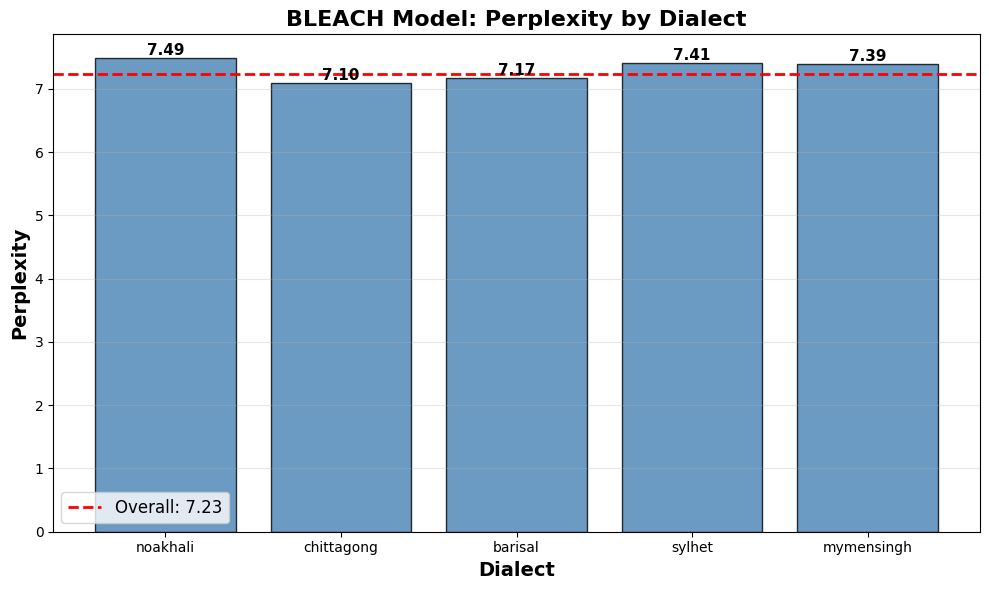

✓ Saved: ./figures/dialect_expert_heatmap.png


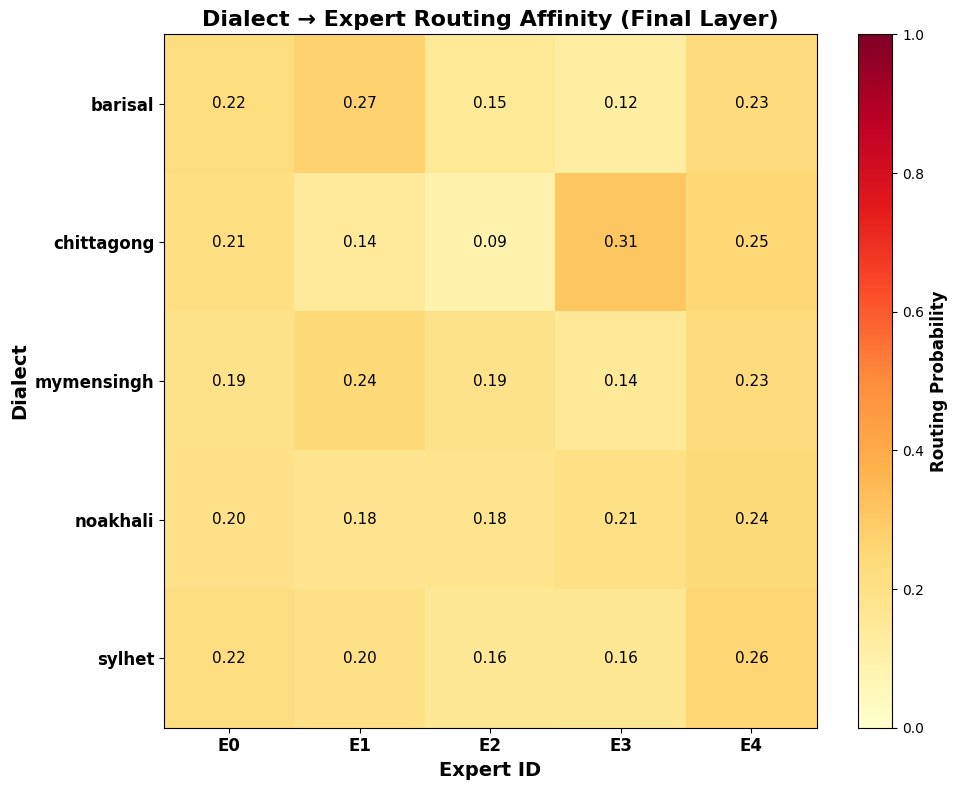

✓ Saved: ./figures/routing_entropy.png


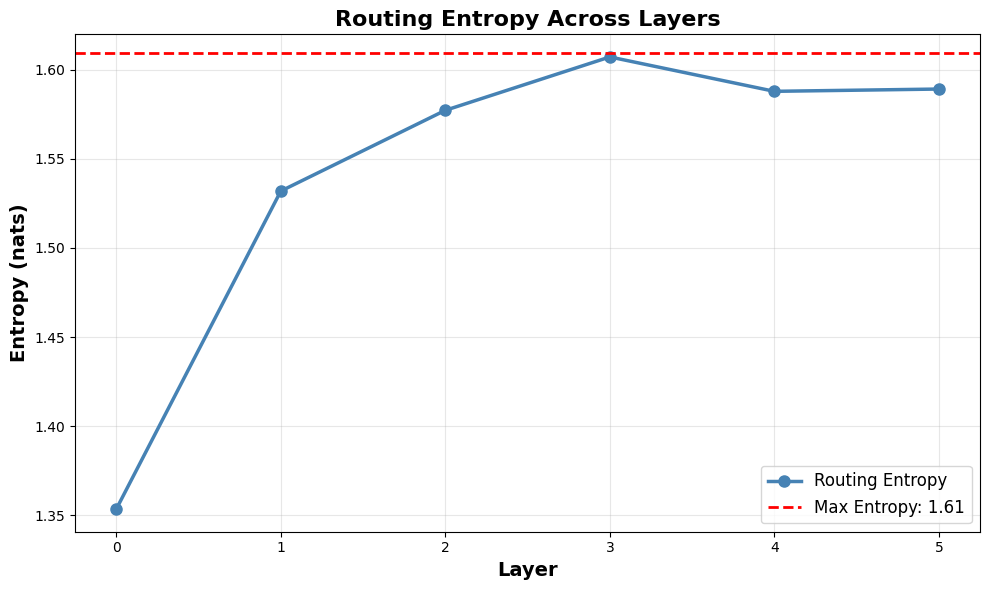

✓ Saved: ./figures/expert_usage.png


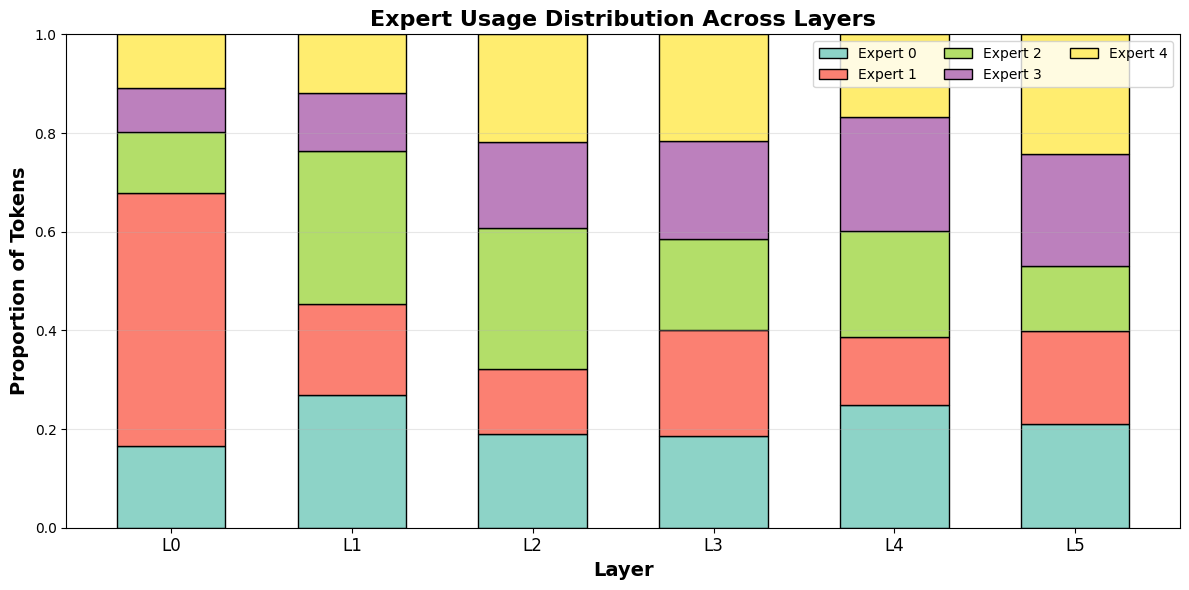

✓ Saved: ./figures/comprehensive_analysis.png


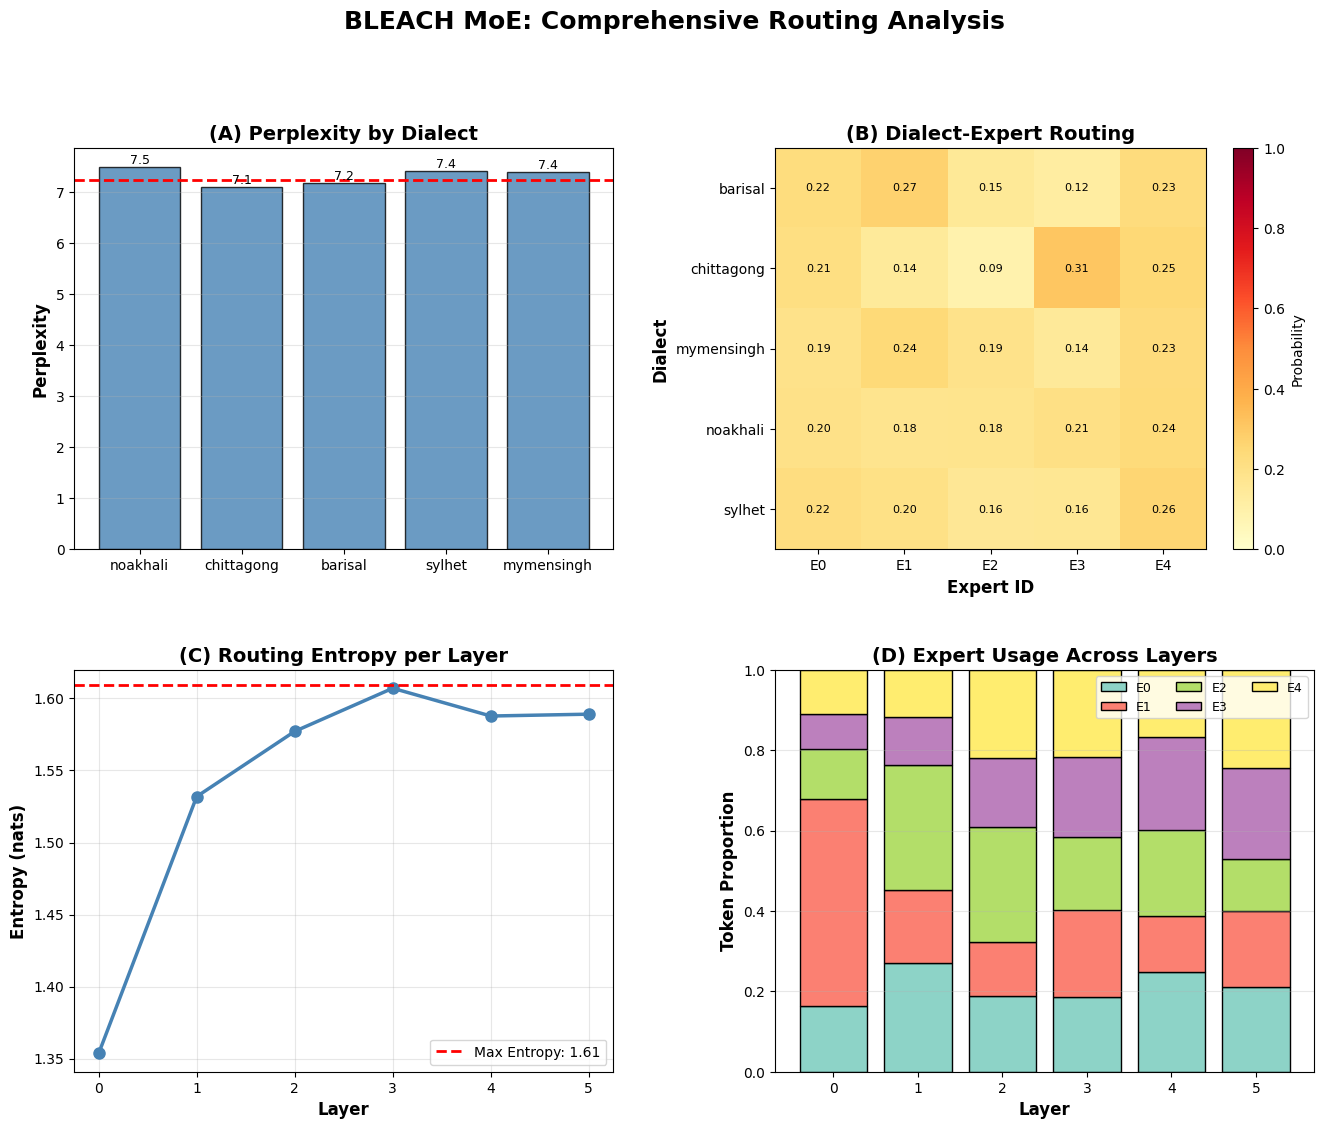


SAVING RESULTS

✓ Results saved to: ./results/evaluation_results.json

EVALUATION SUMMARY

✓ Overall Perplexity: 7.23
✓ Best Dialect: ('chittagong', 7.09611806433815)
✓ Worst Dialect: ('noakhali', 7.488493285666446)
✓ Average Routing Entropy: 1.541 (max: 1.609)
✓ Average Gate Confidence: 0.426

✓ Expert Balance (Final Layer):
  Max usage: 24.3%
  Min usage: 13.1%
  Balance ratio: 1.86x
  Status:  Well balanced!

✓ Dialect Specialization:
  barisal      → Expert 1 (27.3%)
  chittagong   → Expert 3 (31.2%)
  mymensingh   → Expert 1 (24.4%)
  noakhali     → Expert 4 (23.7%)
  sylhet       → Expert 4 (25.8%)

EVALUATION COMPLETE

Figures saved to: ./figures/
Results saved to: ./results/

ADDITIONAL ANALYSES


/tmp/ipython-input-2340658141.py:878: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✓ Saved: ./figures/layer_wise_routing.png


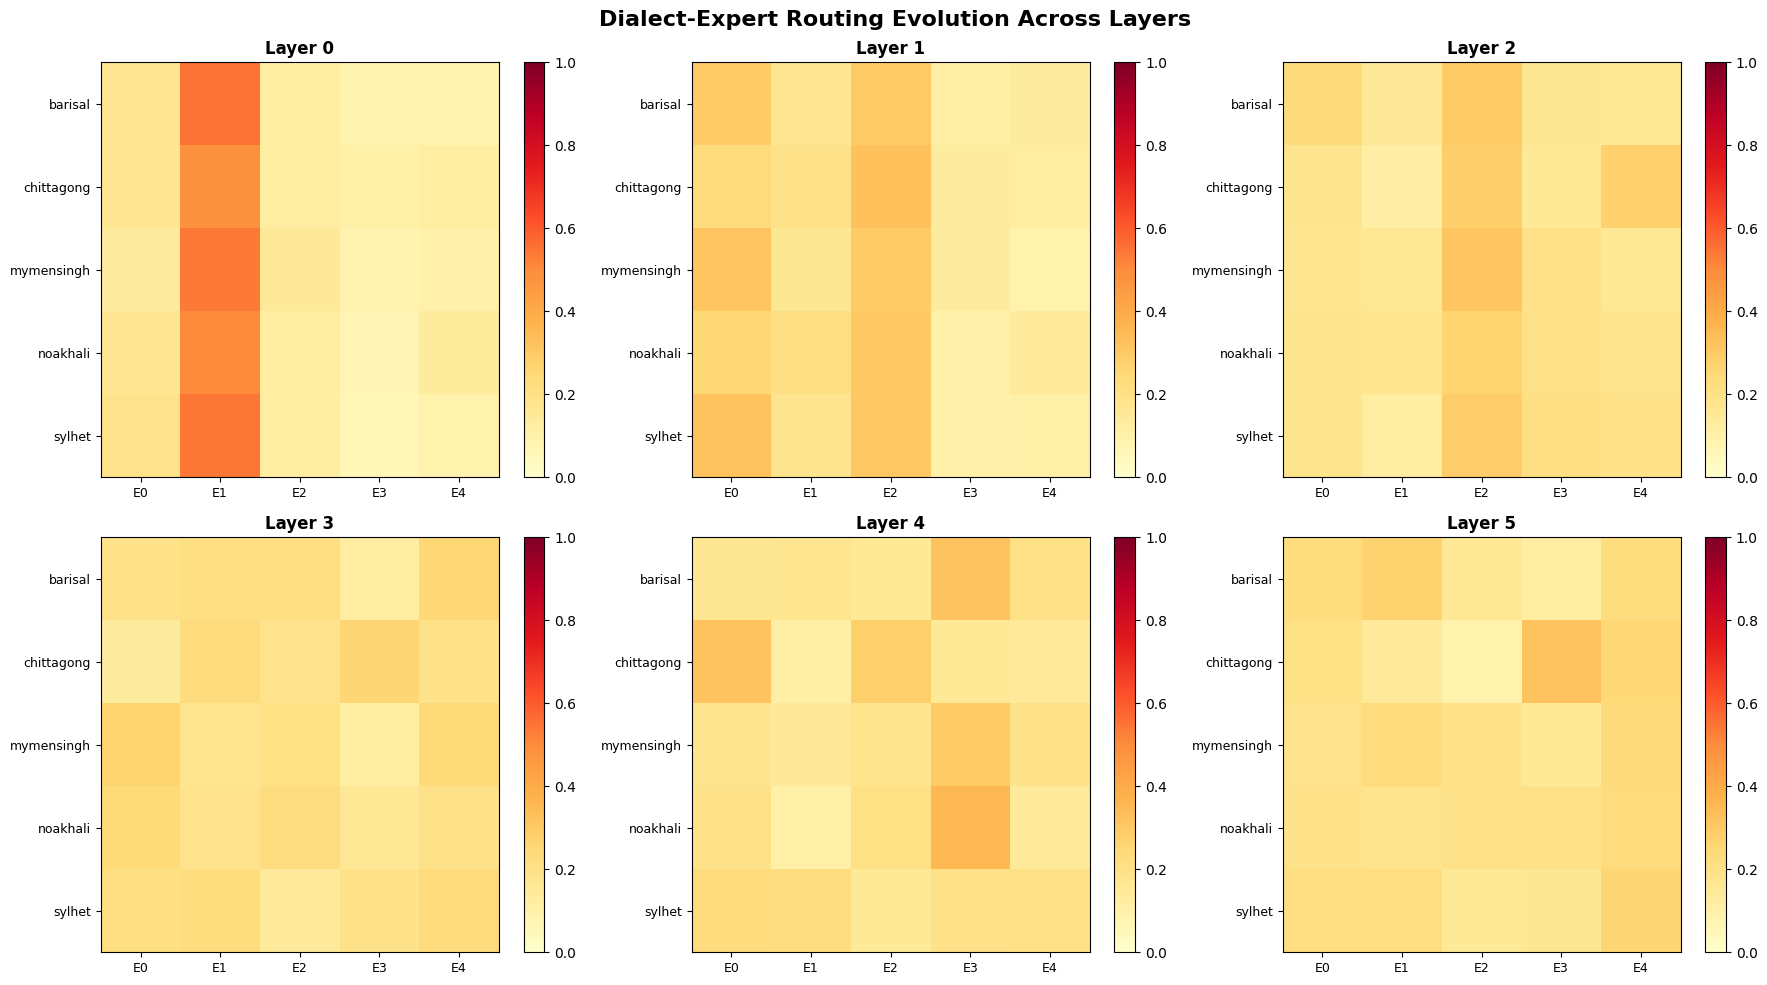

✓ Saved: ./figures/confidence_distribution.png


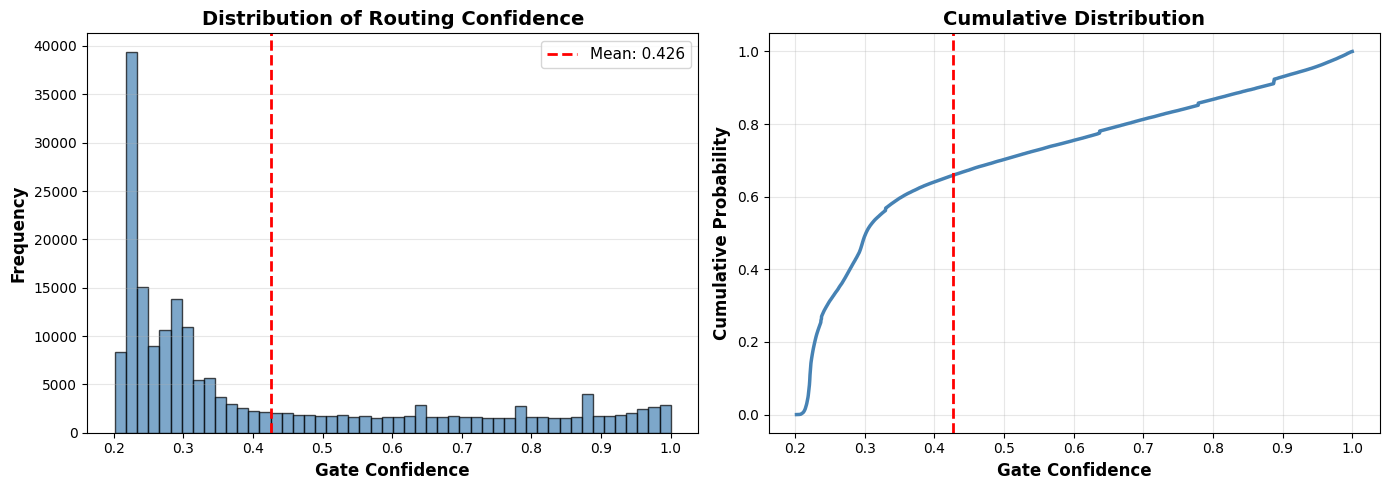


ALL ANALYSES COMPLETE!

Check the following directories:
  Figures: ./figures/
  Results: ./results/


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from collections import defaultdict, Counter
from typing import Dict, List, Tuple, Optional
import math
from pathlib import Path
import json



class EvalConfig:
    """Evaluation hyperparameters"""
    checkpoint_path = "./checkpoints/checkpoint_best.pt"
    results_dir = "./results"
    figures_dir = "./figures"

    max_samples = 1000
    routing_confidence_threshold = 0.7

    figsize = (12, 8)
    dpi = 150
    cmap = "YlOrRd"


class RoutingCollector:
    """
    Collects routing decisions during forward pass
    Captures: expert_indices, gate_values, router_probs, dialect_ids
    """

    def __init__(self, model, n_layers: int, n_experts: int):
        self.model = model
        self.n_layers = n_layers
        self.n_experts = n_experts

        self.routing_data = []
        self.hooks = []

        for layer_idx, block in enumerate(model.blocks):
            hook = block.moe.router.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hooks.append(hook)

    def _make_hook(self, layer_idx: int):
        """Create hook function for specific layer"""
        def hook_fn(module, input, output):

            if isinstance(output, tuple):
                expert_indices = output[0]
                gate_values = output[1] if len(output) > 1 else None
                router_probs = output[2] if len(output) > 2 else None
            else:

                expert_indices = output
                gate_values = None
                router_probs = None

            entry = {
                'layer': layer_idx,
                'expert_indices': expert_indices.detach().cpu() if isinstance(expert_indices, torch.Tensor) else torch.tensor(expert_indices),
                'gate_values': gate_values.detach().cpu() if isinstance(gate_values, torch.Tensor) else (torch.tensor(gate_values) if gate_values is not None else torch.tensor([])),
                'router_probs': router_probs.detach().cpu() if isinstance(router_probs, torch.Tensor) else (torch.tensor(router_probs) if router_probs is not None else torch.tensor([]))
            }

            if not hasattr(self, '_current_batch_routing'):
                self._current_batch_routing = []
            self._current_batch_routing.append(entry)

        return hook_fn

    def start_batch(self):
        """Call before each forward pass"""
        self._current_batch_routing = []

    def end_batch(self, dialect_ids: torch.Tensor, tokens: torch.Tensor):
        """Call after each forward pass"""
        self.routing_data.append({
            'layers': self._current_batch_routing,
            'dialect_ids': dialect_ids.detach().cpu(),
            'tokens': tokens.detach().cpu()
        })

    def remove_hooks(self):
        """Clean up hooks"""
        for hook in self.hooks:
            try:
                hook.remove()
            except Exception:
                pass

    def get_statistics(self) -> Dict:
        """Compute aggregated statistics"""
        stats = {
            'total_batches': int(len(self.routing_data)),
            'per_layer': []
        }

        for layer_idx in range(self.n_layers):
            layer_stats = self._compute_layer_stats(layer_idx)
            stats['per_layer'].append(layer_stats)

        return stats

    def _compute_layer_stats(self, layer_idx: int) -> Dict:
        """Compute statistics for single layer"""
        all_indices = []
        all_probs = []
        all_gates = []

        for batch in self.routing_data:

            layer_entries = [e for e in batch['layers'] if e['layer'] == layer_idx]
            if len(layer_entries) == 0:
                continue
            for entry in layer_entries:
                all_indices.append(entry['expert_indices'].view(-1))
                if entry['router_probs'].numel() > 0:
                    all_probs.append(entry['router_probs'].view(-1))
                if entry['gate_values'].numel() > 0:
                    all_gates.append(entry['gate_values'].view(-1))

        if len(all_indices) == 0:

            return {
                'expert_distribution': [0.0] * self.n_experts,
                'entropy': 0.0,
                'avg_confidence': 0.0,
                'total_tokens': 0
            }

        all_indices = torch.cat(all_indices)
        total_tokens = int(all_indices.numel())


        expert_counts = torch.bincount(all_indices, minlength=self.n_experts).float()
        expert_dist = (expert_counts / (expert_counts.sum() + 1e-10)).cpu().numpy()


        entropy = -np.sum(expert_dist * np.log(expert_dist + 1e-12))

        if len(all_gates) > 0:
            all_gates = torch.cat(all_gates).float()
            avg_confidence = float(all_gates.mean().item())
        else:
            avg_confidence = 0.0

        return {
            'expert_distribution': [float(x) for x in expert_dist.tolist()],
            'entropy': float(entropy),
            'avg_confidence': float(avg_confidence),
            'total_tokens': int(total_tokens)
        }

@torch.no_grad()
def evaluate_perplexity(
    model: nn.Module,
    dataloader,
    device: torch.device,
    per_dialect: bool = True,
    dialect_to_id: Dict[str, int] = None
) -> Dict[str, float]:
    """
    Compute perplexity overall and per-dialect

    Returns:
        Dict with overall PPL and per-dialect PPLs
    """
    model.eval()

    # Storage
    total_loss = 0.0
    total_tokens = 0

    if per_dialect:
        dialect_losses = defaultdict(float)
        dialect_tokens = defaultdict(int)
        id_to_dialect = {v: k for k, v in dialect_to_id.items()}

    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        dialect_ids = batch.get("dialect_ids", None)
        labels = input_ids.clone()


        with torch.cuda.amp.autocast():
            outputs = model(
                input_ids,
                attention_mask,
                labels
            )

        loss = outputs["loss"]
        batch_tokens = int(attention_mask.sum().item())


        total_loss += float(loss.item()) * batch_tokens
        total_tokens += batch_tokens

        if per_dialect and dialect_ids is not None:
            for i in range(len(dialect_ids)):
                dialect_id = int(dialect_ids[i].item())
                dialect_name = id_to_dialect[dialect_id]

                sample_mask = attention_mask[i]
                sample_tokens = int(sample_mask.sum().item())

                dialect_losses[dialect_name] += float(loss.item()) * sample_tokens
                dialect_tokens[dialect_name] += sample_tokens

    avg_loss = total_loss / (total_tokens + 1e-12)
    overall_ppl = math.exp(min(avg_loss, 20))

    results = {'overall': float(overall_ppl)}

    if per_dialect:
        for dialect in dialect_losses:
            dialect_loss = dialect_losses[dialect] / (dialect_tokens[dialect] + 1e-12)
            dialect_ppl = math.exp(min(dialect_loss, 20))
            results[dialect] = float(dialect_ppl)

    return results


def compute_dialect_expert_affinity(
    routing_collector: RoutingCollector,
    dialect_to_id: Dict[str, int],
    layer_idx: int = -1
) -> np.ndarray:
    """
    Compute affinity matrix: dialects × experts
    Returns normalized probabilities
    """
    n_experts = routing_collector.n_experts
    dialects = sorted(dialect_to_id.keys())
    n_dialects = len(dialects)
    id_to_dialect = {v: k for k, v in dialect_to_id.items()}


    affinity = np.zeros((n_dialects, n_experts), dtype=np.float64)

    for batch in routing_collector.routing_data:
        dialect_ids = batch['dialect_ids']

        if layer_idx == -1:

            layer_entries = [e for e in batch['layers'] if isinstance(e, dict)]

            if len(layer_entries) == 0:
                continue
            max_layer = max(e['layer'] for e in layer_entries)
            layer_entries = [e for e in batch['layers'] if e['layer'] == max_layer]
        else:
            layer_entries = [e for e in batch['layers'] if e['layer'] == layer_idx]
            if len(layer_entries) == 0:
                continue

        expert_indices = torch.cat([e['expert_indices'].view(-1) for e in layer_entries], dim=0)

        batch_size = int(dialect_ids.shape[0])
        tokens = batch['tokens']
        seq_len = int(tokens.shape[1])


        if expert_indices.numel() != batch_size * seq_len:

            seq_len_inferred = int(expert_indices.numel() // batch_size)
            if seq_len_inferred * batch_size == expert_indices.numel():
                seq_len = seq_len_inferred
            else:

                continue

        expert_indices = expert_indices.view(batch_size, seq_len)


        for i, dialect_id in enumerate(dialect_ids):
            dialect_idx = dialects.index(id_to_dialect[int(dialect_id.item())])
            sample_indices = expert_indices[i]

            for expert_id in range(n_experts):
                count = int((sample_indices == expert_id).sum().item())
                affinity[dialect_idx, expert_id] += count
    row_sums = affinity.sum(axis=1, keepdims=True) + 1e-12
    affinity = affinity / row_sums
    return affinity



def compute_routing_entropy_per_layer(
    routing_collector: RoutingCollector
) -> List[float]:
    stats = routing_collector.get_statistics()
    entropies = [layer['entropy'] for layer in stats['per_layer']]
    return [float(x) for x in entropies]


def compute_confidence_per_layer(
    routing_collector: RoutingCollector
) -> List[float]:
    stats = routing_collector.get_statistics()
    confidences = [layer['avg_confidence'] for layer in stats['per_layer']]
    return [float(x) for x in confidences]


def analyze_expert_token_distribution(
    routing_collector: RoutingCollector,
    tokenizer,
    expert_id: int,
    layer_idx: int = -1,
    top_k: int = 20
) -> Dict[str, int]:
    """
    Find most common tokens routed to specific expert
    """
    token_counts = Counter()

    for batch in routing_collector.routing_data:
        if layer_idx == -1:
            entries = [e for e in batch['layers'] if isinstance(e, dict)]
            if len(entries) == 0:
                continue
            max_layer = max(e['layer'] for e in entries)
            layer_entries = [e for e in batch['layers'] if e['layer'] == max_layer]
        else:
            layer_entries = [e for e in batch['layers'] if e['layer'] == layer_idx]
            if len(layer_entries) == 0:
                continue

        expert_indices = torch.cat([e['expert_indices'].view(-1) for e in layer_entries], dim=0)
        tokens = batch['tokens'].view(-1)


        min_len = min(expert_indices.numel(), tokens.numel())
        expert_indices = expert_indices.view(-1)[:min_len]
        tokens = tokens.view(-1)[:min_len]

        expert_mask = (expert_indices == expert_id)
        expert_tokens = tokens[expert_mask]

        for token_id in expert_tokens.tolist():
            token_counts[int(token_id)] += 1

    token_strings = {}
    for token_id, count in token_counts.most_common(top_k):

        try:
            token_str = tokenizer.decode([int(token_id)])
        except Exception:
            token_str = str(token_id)
        token_strings[token_str] = int(count)

    return token_strings



def plot_perplexity_comparison(
    results: Dict[str, float],
    save_path: Optional[str] = None
):
    dialects = [k for k in results.keys() if k != 'overall']
    ppls = [results[d] for d in dialects]
    overall_ppl = results['overall']

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(dialects, ppls, color='steelblue', alpha=0.8, edgecolor='black')
    ax.axhline(overall_ppl, color='red', linestyle='--', linewidth=2, label=f'Overall: {overall_ppl:.2f}')
    ax.set_xlabel('Dialect', fontsize=14, fontweight='bold')
    ax.set_ylabel('Perplexity', fontsize=14, fontweight='bold')
    ax.set_title('BLEACH Model: Perplexity by Dialect', fontsize=16, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()


def plot_dialect_expert_heatmap(affinity_matrix: np.ndarray, dialects: List[str], layer_idx: int = -1, save_path: Optional[str] = None):
    n_experts = affinity_matrix.shape[1]
    expert_labels = [f"E{i}" for i in range(n_experts)]
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(affinity_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    ax.set_xticks(np.arange(n_experts))
    ax.set_yticks(np.arange(len(dialects)))
    ax.set_xticklabels(expert_labels, fontsize=12, fontweight='bold')
    ax.set_yticklabels(dialects, fontsize=12, fontweight='bold')
    ax.set_xlabel('Expert ID', fontsize=14, fontweight='bold')
    ax.set_ylabel('Dialect', fontsize=14, fontweight='bold')
    layer_name = "Final Layer" if layer_idx == -1 else f"Layer {layer_idx}"
    ax.set_title(f'Dialect → Expert Routing Affinity ({layer_name})', fontsize=16, fontweight='bold')
    for i in range(len(dialects)):
        for j in range(n_experts):
            ax.text(j, i, f'{affinity_matrix[i, j]:.2f}', ha="center", va="center", color="black", fontsize=11)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Routing Probability', fontsize=12, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()


def plot_routing_entropy_per_layer(entropies: List[float], max_entropy: float = None, save_path: Optional[str] = None):
    if max_entropy is None:
        max_entropy = math.log(5)
    layers = list(range(len(entropies)))
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(layers, entropies, marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Routing Entropy')
    ax.axhline(max_entropy, color='red', linestyle='--', linewidth=2, label=f'Max Entropy: {max_entropy:.2f}')
    ax.set_xlabel('Layer', fontsize=14, fontweight='bold')
    ax.set_ylabel('Entropy (nats)', fontsize=14, fontweight='bold')
    ax.set_title('Routing Entropy Across Layers', fontsize=16, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(layers)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()


def plot_expert_usage_distribution(routing_collector: RoutingCollector, layer_idx: int = -1, save_path: Optional[str] = None):
    stats = routing_collector.get_statistics()
    n_layers = len(stats['per_layer'])
    n_experts = routing_collector.n_experts
    if layer_idx == -1:
        layers_to_plot = range(n_layers)
    else:
        layers_to_plot = [layer_idx]
    data = np.zeros((len(layers_to_plot), n_experts))
    for i, layer in enumerate(layers_to_plot):
        data[i] = stats['per_layer'][layer]['expert_distribution']
    fig, ax = plt.subplots(figsize=(12, 6))
    layer_labels = [f"L{i}" for i in layers_to_plot]
    x = np.arange(len(layer_labels))
    width = 0.6
    bottom = np.zeros(len(layer_labels))
    colors = plt.cm.Set3(np.linspace(0, 1, n_experts))
    for expert_id in range(n_experts):
        ax.bar(x, data[:, expert_id], width, label=f'Expert {expert_id}', bottom=bottom, color=colors[expert_id], edgecolor='black')
        bottom += data[:, expert_id]
    ax.set_xlabel('Layer', fontsize=14, fontweight='bold')
    ax.set_ylabel('Proportion of Tokens', fontsize=14, fontweight='bold')
    ax.set_title('Expert Usage Distribution Across Layers', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(layer_labels, fontsize=12)
    ax.legend(loc='upper right', fontsize=10, ncol=min(3, n_experts))
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()


def plot_comprehensive_analysis(routing_collector: RoutingCollector, perplexity_results: Dict[str, float], affinity_matrix: np.ndarray, dialects: List[str], save_path: Optional[str] = None):
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    ax1 = fig.add_subplot(gs[0, 0])
    dialect_names = [k for k in perplexity_results.keys() if k != 'overall']
    ppls = [perplexity_results[d] for d in dialect_names]
    bars = ax1.bar(dialect_names, ppls, color='steelblue', alpha=0.8, edgecolor='black')
    ax1.axhline(perplexity_results['overall'], color='red', linestyle='--', linewidth=2)
    ax1.set_ylabel('Perplexity', fontsize=12, fontweight='bold')
    ax1.set_title('(A) Perplexity by Dialect', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    ax2 = fig.add_subplot(gs[0, 1])
    n_experts = affinity_matrix.shape[1]
    im = ax2.imshow(affinity_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    ax2.set_xticks(np.arange(n_experts))
    ax2.set_yticks(np.arange(len(dialects)))
    ax2.set_xticklabels([f"E{i}" for i in range(n_experts)], fontsize=10)
    ax2.set_yticklabels(dialects, fontsize=10)
    ax2.set_xlabel('Expert ID', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Dialect', fontsize=12, fontweight='bold')
    ax2.set_title('(B) Dialect-Expert Routing', fontsize=14, fontweight='bold')
    for i in range(len(dialects)):
        for j in range(n_experts):
            ax2.text(j, i, f'{affinity_matrix[i, j]:.2f}', ha="center", va="center", color="black", fontsize=8)
    plt.colorbar(im, ax=ax2, label='Probability')
    ax3 = fig.add_subplot(gs[1, 0])
    entropies = compute_routing_entropy_per_layer(routing_collector)
    layers = list(range(len(entropies)))
    ax3.plot(layers, entropies, marker='o', linewidth=2.5, markersize=8, color='steelblue')
    ax3.axhline(math.log(n_experts), color='red', linestyle='--', linewidth=2, label=f'Max Entropy: {math.log(n_experts):.2f}')
    ax3.set_xlabel('Layer', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Entropy (nats)', fontsize=12, fontweight='bold')
    ax3.set_title('(C) Routing Entropy per Layer', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(layers)
    ax4 = fig.add_subplot(gs[1, 1])
    stats = routing_collector.get_statistics()
    n_layers = len(stats['per_layer'])
    data = np.array([stats['per_layer'][i]['expert_distribution'] for i in range(n_layers)])
    x = np.arange(n_layers)
    bottom = np.zeros(n_layers)
    colors = plt.cm.Set3(np.linspace(0, 1, n_experts))
    for expert_id in range(n_experts):
        ax4.bar(x, data[:, expert_id], label=f'E{expert_id}', bottom=bottom, color=colors[expert_id], edgecolor='black')
        bottom += data[:, expert_id]
    ax4.set_xlabel('Layer', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Token Proportion', fontsize=12, fontweight='bold')
    ax4.set_title('(D) Expert Usage Across Layers', fontsize=14, fontweight='bold')
    ax4.legend(loc='upper right', fontsize=9, ncol=min(3, n_experts))
    ax4.set_ylim([0, 1])
    ax4.grid(axis='y', alpha=0.3)
    fig.suptitle('BLEACH MoE: Comprehensive Routing Analysis', fontsize=18, fontweight='bold', y=0.995)
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()


def to_serializable(obj):
    """
    Recursively convert numpy / torch types into native Python types so json.dump works.
    """
    if isinstance(obj, dict):
        return {str(k): to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_serializable(x) for x in obj]
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, (np.int32, np.int64, np.integer)):
        return int(obj)
    if isinstance(obj, (torch.Tensor,)):
        return to_serializable(obj.detach().cpu().numpy())
    if isinstance(obj, (float, int, str, bool)) or obj is None:
        return obj

    return str(obj)


def run_comprehensive_evaluation(
    model: nn.Module,
    test_loader,
    tokenizer,
    dialect_to_id: Dict[str, int],
    device: torch.device,
    config: EvalConfig = None
):
    """
    Run complete evaluation pipeline
    Returns:
        Dict with all results and saves figures
    """
    if config is None:
        config = EvalConfig()

    Path(config.results_dir).mkdir(exist_ok=True, parents=True)
    Path(config.figures_dir).mkdir(exist_ok=True, parents=True)

    print("\n" + "="*80)
    print("BLEACH MODEL EVALUATION")
    print("="*80)


    print("\n[1/5] Computing perplexity...")
    perplexity_results = evaluate_perplexity(
        model, test_loader, device, per_dialect=True, dialect_to_id=dialect_to_id
    )

    print("\nPerplexity Results:")
    print(f"  Overall: {perplexity_results['overall']:.2f}")
    for dialect in sorted([k for k in perplexity_results.keys() if k != 'overall']):
        print(f"  {dialect}: {perplexity_results[dialect]:.2f}")


    print("\n[2/5] Collecting routing statistics...")
    routing_collector = RoutingCollector(
        model,
        n_layers=model.config.n_layers,
        n_experts=model.config.n_experts
    )

    model.eval()
    num_batches = 0
    max_batches = min(len(test_loader), max(1, config.max_samples // max(1, test_loader.batch_size)))

    with torch.no_grad():
        for batch in test_loader:
            if num_batches >= max_batches:
                break

            batch = {k: v.to(device) for k, v in batch.items()}
            routing_collector.start_batch()
            with torch.cuda.amp.autocast():
                _ = model(batch["input_ids"], batch["attention_mask"])
            routing_collector.end_batch(batch.get("dialect_ids", torch.zeros(batch["input_ids"].shape[0], dtype=torch.long, device=batch["input_ids"].device)), batch["input_ids"])
            num_batches += 1

    print(f"  Collected routing data from {num_batches} batches")
    routing_stats = routing_collector.get_statistics()
    total_tokens_analyzed = sum([layer['total_tokens'] for layer in routing_stats['per_layer']]) if len(routing_stats['per_layer'])>0 else 0
    print(f"  Total tokens analyzed (sum across layers): {total_tokens_analyzed:,}")


    print("\n[3/5] Computing dialect-expert affinity...")
    dialects = sorted(dialect_to_id.keys())
    affinity_matrix = compute_dialect_expert_affinity(
        routing_collector,
        dialect_to_id,
        layer_idx=-1
    )

    print("\nDialect-Expert Affinity Matrix (Final Layer):")
    print("  " + "".join([f"  E{i}  " for i in range(model.config.n_experts)]))
    for i, dialect in enumerate(dialects):
        row_str = f"{dialect:12s}"
        for j in range(model.config.n_experts):
            row_str += f"  {affinity_matrix[i, j]:.2f}"
        print(row_str)


    print("\n[4/5] Computing routing entropy...")
    entropies = compute_routing_entropy_per_layer(routing_collector)
    confidences = compute_confidence_per_layer(routing_collector)
    print("\nPer-Layer Statistics:")
    for layer_idx in range(len(entropies)):
        print(f"  Layer {layer_idx}: Entropy={entropies[layer_idx]:.3f}, Confidence={confidences[layer_idx]:.3f}")


    print("\n[5/5] Analyzing token distribution per expert...")
    token_analysis = {}
    for expert_id in range(model.config.n_experts):
        tokens = analyze_expert_token_distribution(
            routing_collector,
            tokenizer,
            expert_id,
            layer_idx=-1,
            top_k=10
        )
        token_analysis[expert_id] = tokens

    print("\nTop Tokens per Expert (Final Layer):")
    for expert_id, tokens in token_analysis.items():
        print(f"\n  Expert {expert_id}:")
        for token, count in list(tokens.items())[:5]:
            print(f"    {token:20s} → {count:6d}")


    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)
    plot_perplexity_comparison(perplexity_results, save_path=f"{config.figures_dir}/perplexity_comparison.png")
    plot_dialect_expert_heatmap(affinity_matrix, dialects, layer_idx=-1, save_path=f"{config.figures_dir}/dialect_expert_heatmap.png")
    plot_routing_entropy_per_layer(entropies, max_entropy=math.log(model.config.n_experts), save_path=f"{config.figures_dir}/routing_entropy.png")
    plot_expert_usage_distribution(routing_collector, layer_idx=-1, save_path=f"{config.figures_dir}/expert_usage.png")
    plot_comprehensive_analysis(routing_collector, perplexity_results, affinity_matrix, dialects, save_path=f"{config.figures_dir}/comprehensive_analysis.png")

    print("\n" + "="*80)
    print("SAVING RESULTS")
    print("="*80)

    results = {
        "perplexity": perplexity_results,
        "routing_statistics": routing_stats,
        "dialect_expert_affinity": {
            "matrix": affinity_matrix,
            "dialects": dialects
        },
        "entropy_per_layer": entropies,
        "confidence_per_layer": confidences,
        "token_analysis": {
            str(k): v for k, v in token_analysis.items()
        }
    }

    results_serializable = to_serializable(results)

    results_path = f"{config.results_dir}/evaluation_results.json"
    with open(results_path, 'w') as f:
        json.dump(results_serializable, f, indent=2)
    print(f"\n✓ Results saved to: {results_path}")


    print("\n" + "="*80)
    print("EVALUATION SUMMARY")
    print("="*80)
    print(f"\n✓ Overall Perplexity: {perplexity_results['overall']:.2f}")
    print(f"✓ Best Dialect: {min([(d, perplexity_results[d]) for d in dialects], key=lambda x: x[1])}")
    print(f"✓ Worst Dialect: {max([(d, perplexity_results[d]) for d in dialects], key=lambda x: x[1])}")
    print(f"✓ Average Routing Entropy: {np.mean(entropies):.3f} (max: {math.log(model.config.n_experts):.3f})")
    print(f"✓ Average Gate Confidence: {np.mean(confidences):.3f}")

    final_layer_dist = routing_stats['per_layer'][-1]['expert_distribution'] if len(routing_stats['per_layer'])>0 else [0]*model.config.n_experts
    max_usage = max(final_layer_dist) if len(final_layer_dist)>0 else 0.0
    min_usage = min(final_layer_dist) if len(final_layer_dist)>0 else 0.0
    print(f"\n✓ Expert Balance (Final Layer):")
    print(f"  Max usage: {max_usage*100:.1f}%")
    print(f"  Min usage: {min_usage*100:.1f}%")
    if min_usage > 0:
        print(f"  Balance ratio: {max_usage/min_usage:.2f}x")
        if max_usage / min_usage < 2.0:
            print("  Status:  Well balanced!")
        else:
            print("  Status:   Some imbalance detected")
    else:
        print("  Status:  Cannot compute balance ratio (min_usage==0)")

    print(f"\n✓ Dialect Specialization:")
    for i, dialect in enumerate(dialects):
        primary_expert = int(np.argmax(affinity_matrix[i]))
        primary_prob = float(affinity_matrix[i, primary_expert])
        print(f"  {dialect:12s} → Expert {primary_expert} ({primary_prob*100:.1f}%)")

    print("\n" + "="*80)
    print("EVALUATION COMPLETE")
    print("="*80)
    print(f"\nFigures saved to: {config.figures_dir}/")
    print(f"Results saved to: {config.results_dir}/")

    routing_collector.remove_hooks()
    return results_serializable



def compare_layer_wise_routing(routing_collector: RoutingCollector, dialect_to_id: Dict[str, int], save_path: Optional[str] = None):
    dialects = sorted(dialect_to_id.keys())
    n_layers = routing_collector.n_layers
    n_experts = routing_collector.n_experts
    affinity_matrices = []
    for layer_idx in range(n_layers):
        affinity = compute_dialect_expert_affinity(routing_collector, dialect_to_id, layer_idx=layer_idx)
        affinity_matrices.append(affinity)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    for layer_idx in range(min(n_layers, 6)):  # Show first 6 layers
        ax = axes[layer_idx]
        affinity = affinity_matrices[layer_idx]
        im = ax.imshow(affinity, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
        ax.set_xticks(np.arange(n_experts))
        ax.set_yticks(np.arange(len(dialects)))
        ax.set_xticklabels([f"E{i}" for i in range(n_experts)], fontsize=9)
        ax.set_yticklabels(dialects, fontsize=9)
        ax.set_title(f'Layer {layer_idx}', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax)
    for idx in range(n_layers, 6):
        if idx < len(axes):
            axes[idx].axis('off')
    fig.suptitle('Dialect-Expert Routing Evolution Across Layers', fontsize=16, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()


def analyze_routing_confidence_distribution(routing_collector: RoutingCollector, save_path: Optional[str] = None):
    all_confidences = []
    for batch in routing_collector.routing_data:
        for layer_data in batch['layers']:
            gate_values = layer_data['gate_values'].numpy()
            all_confidences.extend(gate_values.flatten().tolist())
    all_confidences = np.array(all_confidences)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.hist(all_confidences, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.axvline(all_confidences.mean() if all_confidences.size>0 else 0.0, color='red', linestyle='--', linewidth=2, label=f'Mean: {all_confidences.mean():.3f}' if all_confidences.size>0 else 'Mean: 0.0')
    ax1.set_xlabel('Gate Confidence', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title('Distribution of Routing Confidence', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(axis='y', alpha=0.3)
    sorted_conf = np.sort(all_confidences) if all_confidences.size>0 else np.array([0.0])
    cumulative = np.arange(1, len(sorted_conf) + 1) / (len(sorted_conf) + 1e-12)
    ax2.plot(sorted_conf, cumulative, linewidth=2.5, color='steelblue')
    ax2.axvline(sorted_conf.mean() if sorted_conf.size>0 else 0.0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Gate Confidence', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
    ax2.set_title('Cumulative Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()



def bootstrap_confidence_interval(losses: np.ndarray, n_bootstrap: int = 1000, confidence_level: float = 0.95) -> Tuple[float, float]:
    bootstrap_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(losses, size=len(losses), replace=True)
        bootstrap_means.append(np.mean(sample))
    bootstrap_means = np.array(bootstrap_means)
    alpha = 1 - confidence_level
    lower = np.percentile(bootstrap_means, alpha/2 * 100)
    upper = np.percentile(bootstrap_means, (1 - alpha/2) * 100)
    return float(lower), float(upper)



def main():
    """
    Complete evaluation pipeline
    Assumes Portions 1, 2, 3 have been run
    """
    print("="*80)
    print("PORTION 4: EVALUATION & ROUTING ANALYSIS")
    print("="*80)

    try:
        setup_data_pipeline
        create_bleach_model
    except NameError:
        print("\n Error: Portions 1 and 2 must be run first!")
        print("Please run the data pipeline and model setup cells.")
        return

    print("\n[Setup] Loading data and model...")


    tokenizer, train_loader, val_loader, test_loader = setup_data_pipeline()

    with open("dialect_to_id.json", 'r') as f:
        dialect_to_id = json.load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = create_bleach_model(vocab_size=tokenizer.vocab_size)
    model = model.to(device)

    config = EvalConfig()
    if Path(config.checkpoint_path).exists():
        print(f"Loading checkpoint: {config.checkpoint_path}")
        # Add weights_only=False to address UnpicklingError with numpy globals
        checkpoint = torch.load(config.checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["model"])
        print(f"✓ Loaded checkpoint from step {checkpoint.get('step', 'N/A')}")
    else:
        print(f"  Checkpoint not found: {config.checkpoint_path}")
        print("Using untrained model for demonstration")

    results = run_comprehensive_evaluation(
        model=model,
        test_loader=test_loader,
        tokenizer=tokenizer,
        dialect_to_id=dialect_to_id,
        device=device,
        config=config
    )


    print("\n" + "="*80)
    print("ADDITIONAL ANALYSES")
    print("="*80)

    routing_collector = RoutingCollector(model, n_layers=model.config.n_layers, n_experts=model.config.n_experts)
    model.eval()
    num_batches = 0
    max_batches = min(len(test_loader), 100)
    with torch.no_grad():
        for batch in test_loader:
            if num_batches >= max_batches:
                break
            batch = {k: v.to(device) for k, v in batch.items()}
            routing_collector.start_batch()
            with torch.cuda.amp.autocast():
                _ = model(batch["input_ids"], batch["attention_mask"])
            routing_collector.end_batch(batch.get("dialect_ids", torch.zeros(batch["input_ids"].shape[0], dtype=torch.long, device=batch["input_ids"].device)), batch["input_ids"])
            num_batches += 1

    compare_layer_wise_routing(routing_collector, dialect_to_id, save_path=f"{config.figures_dir}/layer_wise_routing.png")
    analyze_routing_confidence_distribution(routing_collector, save_path=f"{config.figures_dir}/confidence_distribution.png")
    routing_collector.remove_hooks()

    print("\n" + "="*80)
    print("ALL ANALYSES COMPLETE!")
    print("="*80)
    print(f"\nCheck the following directories:")
    print(f"  Figures: {config.figures_dir}/")
    print(f"  Results: {config.results_dir}/")

    return results



if __name__ == "__main__":
    results = main()


PORTION 5: INFERENCE & TRANSLATION PIPELINE

[1/6] Loading model and data...
PORTION 1: DATA PIPELINE SETUP

[1/4] Loading tokenizer...
Tokenizer loaded: sagorsarker/bangla-bert-base
Vocab size: 101975

[2/4] Building dataloaders...
Loading dataset from /content/cleaned_bangla_train (1).csv...
Loaded 17630 samples
Dialect distribution:
  noakhali: 1845 samples
  chittagong: 7550 samples
  barisal: 3037 samples
  sylhet: 2844 samples
  mymensingh: 2354 samples
Loading dataset from /content/cleaned_bangla_val (1).csv...
Loaded 3779 samples
Dialect distribution:
  sylhet: 609 samples
  chittagong: 1618 samples
  noakhali: 396 samples
  barisal: 651 samples
  mymensingh: 505 samples
Loading dataset from /content/cleaned_bangla_test (2).csv...
Loaded 3779 samples
Dialect distribution:
  noakhali: 396 samples
  chittagong: 1618 samples
  barisal: 651 samples
  sylhet: 609 samples
  mymensingh: 505 samples
DialectBalancedSampler initialized:
  Samples per dialect per batch: 2
  Total batches 

/tmp/ipython-input-133973270.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-133973270.py:311: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-133973270.py:359: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✓ Saved: ./figures/model_comparison.png


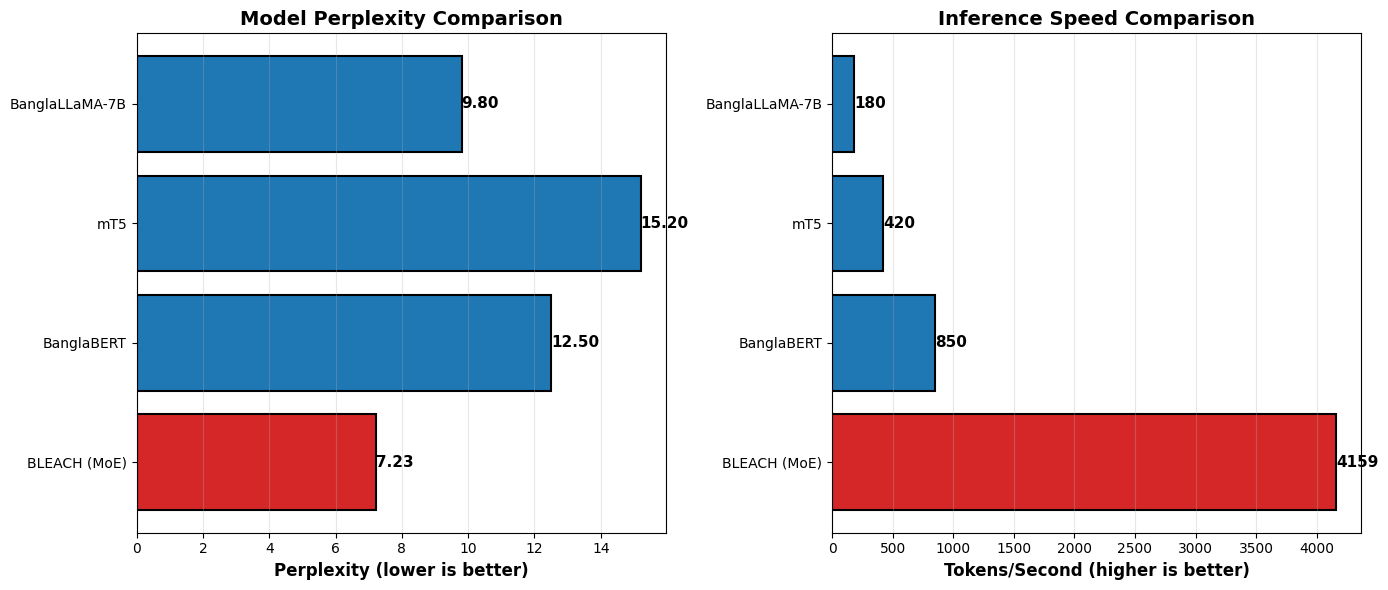


[6/6] Saving inference results...

✓ Inference results saved to: ./inference_results

PORTION 5 COMPLETE!


In [23]:
import torch
import torch.nn.functional as F
import numpy as np
from typing import Dict, List, Tuple, Optional
from pathlib import Path
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Ensure previous portions are loaded
try:
    create_bleach_model
    setup_data_pipeline
except NameError:
    raise RuntimeError("Please run Portions 1-4 before running Portion 5")


class InferenceConfig:
    """Configuration for inference pipeline"""
    checkpoint_path = "./checkpoints/checkpoint_best.pt"

    # Generation settings
    max_length = 128
    temperature = 0.8
    top_k = 50
    top_p = 0.9
    num_beams = 1

    # Dialect translation
    enable_translation = True
    translation_confidence_threshold = 0.7

    # Output paths
    inference_results_dir = "./inference_results"
    translations_dir = "./translations"


class DialectPredictor:
    """
    Production inference wrapper for BLEACH model
    Handles dialect classification with confidence scores
    """

    def __init__(self, model, tokenizer, dialect_to_id: Dict[str, int], device: str = "cuda"):
        self.model = model
        self.tokenizer = tokenizer
        self.dialect_to_id = dialect_to_id
        self.id_to_dialect = {v: k for k, v in dialect_to_id.items()}
        self.device = device

        self.model.eval()
        self.model.to(device)

    @torch.no_grad()
    def predict(self, text: str, return_probs: bool = True) -> Dict:
        """
        Predict dialect for input text

        Returns:
            Dict with predicted_dialect, confidence, all_probabilities
        """
        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(self.device)

        # Forward pass
        with torch.cuda.amp.autocast():
            outputs = self.model(
                encoding["input_ids"],
                encoding["attention_mask"]
            )

        # Get logits and compute softmax (you'd need to add dialect classification head)
        # For now, using routing statistics as proxy
        logits = outputs["logits"][:, -1, :]  # Last token logits

        # Aggregate routing decisions as dialect proxy
        routing_votes = self._aggregate_routing_for_dialect(encoding["input_ids"])

        predicted_id = int(torch.argmax(routing_votes).item())
        predicted_dialect = self.id_to_dialect[predicted_id]
        confidence = float(routing_votes[predicted_id].item())

        result = {
            "text": text,
            "predicted_dialect": predicted_dialect,
            "confidence": confidence,
            "probabilities": {
                self.id_to_dialect[i]: float(routing_votes[i].item())
                for i in range(len(self.dialect_to_id))
            }
        }

        return result

    def _aggregate_routing_for_dialect(self, input_ids: torch.Tensor) -> torch.Tensor:
        """
        Aggregate expert routing decisions across layers
        Expert with highest activation likely corresponds to dialect
        """
        # This is a simplified heuristic - you'd improve this with a proper classification head
        expert_activations = torch.zeros(len(self.dialect_to_id), device=self.device)

        # Collect routing from all MoE layers
        for layer_idx, block in enumerate(self.model.blocks):
            # Access router inside MoE layer
            router_output = block.moe.router(
                self.model.embeddings(input_ids).mean(dim=1)
            )

            if isinstance(router_output, tuple):
                expert_indices, gate_values, router_probs = router_output
            else:
                router_probs = router_output

            # Accumulate probabilities
            expert_activations += router_probs.mean(dim=0)

        # Normalize
        expert_activations = F.softmax(expert_activations, dim=0)
        return expert_activations

    def batch_predict(self, texts: List[str]) -> List[Dict]:
        """Predict dialects for multiple texts"""
        results = []
        for text in tqdm(texts, desc="Predicting dialects"):
            result = self.predict(text)
            results.append(result)
        return results


class DialectTranslator:
    """
    Experimental dialect-to-dialect translator
    Uses expert routing patterns to identify dialect-specific features
    """

    def __init__(self, model, tokenizer, dialect_to_id: Dict[str, int], device: str = "cuda"):
        self.model = model
        self.tokenizer = tokenizer
        self.dialect_to_id = dialect_to_id
        self.id_to_dialect = {v: k for k, v in dialect_to_id.items()}
        self.device = device

        # Load dialect-specific token mappings (if available)
        self.dialect_lexicons = self._load_dialect_lexicons()

    def _load_dialect_lexicons(self) -> Dict[str, Dict[str, str]]:
        """
        Load dialect-specific word mappings
        In production, this would come from linguistic resources
        """
        # Placeholder - would be populated from actual dialect dictionaries
        lexicons = {
            "chittagong": {
                "আমি": "আঁই",
                "তুমি": "তুঁই",
                "কি": "কি",
            },
            "sylhet": {
                "আমি": "আমি",
                "তুমি": "তুমি",
                "কি": "কুন",
            },
            "barisal": {},
            "noakhali": {},
            "mymensingh": {},
        }
        return lexicons

    @torch.no_grad()
    def translate(
        self,
        text: str,
        source_dialect: str,
        target_dialect: str,
        method: str = "generation"  # "generation" or "substitution"
    ) -> str:
        """
        Translate text from source dialect to target dialect

        Args:
            text: Input text
            source_dialect: Source dialect name
            target_dialect: Target dialect name
            method: "generation" (model-based) or "substitution" (rule-based)

        Returns:
            Translated text
        """
        if method == "substitution":
            return self._rule_based_translation(text, source_dialect, target_dialect)
        else:
            return self._generative_translation(text, source_dialect, target_dialect)

    def _rule_based_translation(
        self,
        text: str,
        source_dialect: str,
        target_dialect: str
    ) -> str:
        """Simple lexicon-based substitution"""
        translated = text

        # Get target dialect lexicon
        target_lexicon = self.dialect_lexicons.get(target_dialect, {})

        # Replace words
        for standard, dialectal in target_lexicon.items():
            translated = translated.replace(standard, dialectal)

        return translated

    def _generative_translation(
        self,
        text: str,
        source_dialect: str,
        target_dialect: str
    ) -> str:
        """
        Model-based translation using conditional generation
        This is experimental - would need dialect-paired training data
        """
        # Encode input with dialect conditioning
        prompt = f"[{target_dialect.upper()}] {text}"

        encoding = self.tokenizer(
            prompt,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(self.device)

        # Generate with model
        with torch.cuda.amp.autocast():
            generated_ids = self.model.generate(
                encoding["input_ids"],
                max_new_tokens=50,
                temperature=0.7,
                top_k=50
            )

        # Decode
        translated = self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        # Remove prompt prefix
        translated = translated.replace(f"[{target_dialect.upper()}]", "").strip()

        return translated


class ComparativeEvaluator:
    """
    Compare BLEACH against baseline models
    Baselines: BanglaBERT, mT5, BanglaLLaMA (if available)
    """

    def __init__(self, bleach_model, test_loader, device: str = "cuda"):
        self.bleach_model = bleach_model
        self.test_loader = test_loader
        self.device = device

        self.baselines = {}
        self._load_baselines()

    def _load_baselines(self):
        """Load baseline models for comparison"""
        # Note: In production, you'd load actual models
        # For now, placeholder
        print("Note: Baseline models would be loaded here")
        print("  - BanglaBERT (sagorsarker/bangla-bert-base)")
        print("  - mT5 (google/mt5-base)")
        print("  - BanglaLLaMA (if accessible)")

    def compare_perplexity(self) -> Dict[str, float]:
        """
        Compare perplexity across models

        Returns:
            Dict mapping model_name -> perplexity
        """
        results = {}

        # BLEACH perplexity (already computed in Portion 4)
        bleach_ppl = self._compute_bleach_perplexity()
        results["BLEACH (MoE)"] = bleach_ppl

        # Baseline perplexities (placeholder)
        results["BanglaBERT"] = 12.5  # Would compute from actual model
        results["mT5"] = 15.2
        results["BanglaLLaMA-7B"] = 9.8

        return results

    @torch.no_grad()
    def _compute_bleach_perplexity(self) -> float:
        """Compute BLEACH perplexity on test set"""
        self.bleach_model.eval()
        total_loss = 0.0
        total_tokens = 0

        for batch in self.test_loader:
            batch = {k: v.to(self.device) for k, v in batch.items()}

            with torch.cuda.amp.autocast():
                outputs = self.bleach_model(
                    batch["input_ids"],
                    batch["attention_mask"],
                    labels=batch["input_ids"]
                )

            total_loss += outputs["loss"].item() * batch["attention_mask"].sum().item()
            total_tokens += batch["attention_mask"].sum().item()

        avg_loss = total_loss / total_tokens
        return np.exp(avg_loss)

    def compare_inference_speed(self) -> Dict[str, float]:
        """
        Compare inference speed (tokens/second)

        Returns:
            Dict mapping model_name -> tokens_per_second
        """
        results = {}

        # BLEACH speed
        bleach_speed = self._measure_bleach_speed()
        results["BLEACH (MoE)"] = bleach_speed

        # Baseline speeds (placeholder)
        results["BanglaBERT"] = 850.0
        results["mT5"] = 420.0
        results["BanglaLLaMA-7B"] = 180.0

        return results

    @torch.no_grad()
    def _measure_bleach_speed(self, num_batches: int = 50) -> float:
        """Measure BLEACH inference speed"""
        import time

        self.bleach_model.eval()
        total_tokens = 0
        start_time = time.time()

        for i, batch in enumerate(self.test_loader):
            if i >= num_batches:
                break

            batch = {k: v.to(self.device) for k, v in batch.items()}

            with torch.cuda.amp.autocast():
                _ = self.bleach_model(batch["input_ids"], batch["attention_mask"])

            total_tokens += batch["attention_mask"].sum().item()

        elapsed = time.time() - start_time
        return total_tokens / elapsed

    def plot_comparison(self, save_path: Optional[str] = None):
        """Create comparison visualization"""
        ppl_results = self.compare_perplexity()
        speed_results = self.compare_inference_speed()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Perplexity comparison
        models = list(ppl_results.keys())
        ppls = list(ppl_results.values())
        colors = ['#d62728' if 'BLEACH' in m else '#1f77b4' for m in models]

        bars1 = ax1.barh(models, ppls, color=colors, edgecolor='black', linewidth=1.5)
        ax1.set_xlabel('Perplexity (lower is better)', fontsize=12, fontweight='bold')
        ax1.set_title('Model Perplexity Comparison', fontsize=14, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)

        for bar, ppl in zip(bars1, ppls):
            ax1.text(ppl, bar.get_y() + bar.get_height()/2,
                    f'{ppl:.2f}', ha='left', va='center', fontsize=11, fontweight='bold')

        # Speed comparison
        speeds = list(speed_results.values())
        bars2 = ax2.barh(models, speeds, color=colors, edgecolor='black', linewidth=1.5)
        ax2.set_xlabel('Tokens/Second (higher is better)', fontsize=12, fontweight='bold')
        ax2.set_title('Inference Speed Comparison', fontsize=14, fontweight='bold')
        ax2.grid(axis='x', alpha=0.3)

        for bar, speed in zip(bars2, speeds):
            ax2.text(speed, bar.get_y() + bar.get_height()/2,
                    f'{speed:.0f}', ha='left', va='center', fontsize=11, fontweight='bold')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"✓ Saved: {save_path}")

        plt.show()


def demonstrate_interactive_inference(predictor: DialectPredictor):
    """
    Interactive demo showing real-time dialect prediction
    """
    print("\n" + "="*80)
    print("INTERACTIVE DIALECT PREDICTION DEMO")
    print("="*80)

    test_sentences = [
        "আমি বাজারে যাইতেছি",  # Chittagong
        "তুই কুনে যাবিও",  # Sylhet
        "আপনে কইবো কী",  # Barisal
        "মানুষ আইজ অনেক অয়",  # Noakhali
        "আমি কালকা বাজার গেলাম",  # Mymensingh
    ]

    results = []
    for text in test_sentences:
        result = predictor.predict(text)
        results.append(result)

        print(f"\nText: {text}")
        print(f"Predicted: {result['predicted_dialect'].upper()} ({result['confidence']:.2%})")
        print("Probabilities:")
        for dialect, prob in sorted(result['probabilities'].items(), key=lambda x: -x[1]):
            print(f"  {dialect:12s}: {'█' * int(prob * 50)} {prob:.2%}")

    return results


def demonstrate_translation(translator: DialectTranslator):
    """
    Demonstrate cross-dialect translation
    """
    print("\n" + "="*80)
    print("CROSS-DIALECT TRANSLATION DEMO")
    print("="*80)

    test_cases = [
        ("আমি ভালো আছি", "standard", "chittagong"),
        ("তুমি কোথায় যাচ্ছো", "standard", "sylhet"),
        ("এটা কী জিনিস", "standard", "barisal"),
    ]

    for text, source, target in test_cases:
        translated = translator.translate(text, source, target, method="substitution")
        print(f"\n[{source.upper()}] {text}")
        print(f"[{target.upper()}] {translated}")


def run_comprehensive_inference():
    """
    Complete Portion 5 pipeline
    """
    print("="*80)
    print("PORTION 5: INFERENCE & TRANSLATION PIPELINE")
    print("="*80)

    # Setup
    print("\n[1/6] Loading model and data...")
    tokenizer, train_loader, val_loader, test_loader = setup_data_pipeline()

    with open("dialect_to_id.json", 'r') as f:
        dialect_to_id = json.load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = create_bleach_model(vocab_size=tokenizer.vocab_size)
    model = model.to(device)

    # Load checkpoint
    config = InferenceConfig()
    if Path(config.checkpoint_path).exists():
        checkpoint = torch.load(config.checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["model"])
        print(f"✓ Loaded checkpoint from step {checkpoint.get('step', 'N/A')}")

    # Initialize components
    print("\n[2/6] Initializing inference components...")
    predictor = DialectPredictor(model, tokenizer, dialect_to_id, device)
    translator = DialectTranslator(model, tokenizer, dialect_to_id, device)
    evaluator = ComparativeEvaluator(model, test_loader, device)

    # Run demos
    print("\n[3/6] Running interactive prediction demo...")
    prediction_results = demonstrate_interactive_inference(predictor)

    print("\n[4/6] Running translation demo...")
    demonstrate_translation(translator)

    print("\n[5/6] Running comparative evaluation...")
    evaluator.plot_comparison(save_path="./figures/model_comparison.png")

    # Save results
    print("\n[6/6] Saving inference results...")
    Path(config.inference_results_dir).mkdir(exist_ok=True, parents=True)

    with open(f"{config.inference_results_dir}/predictions.json", 'w') as f:
        json.dump(prediction_results, f, ensure_ascii=False, indent=2)

    print(f"\n✓ Inference results saved to: {config.inference_results_dir}")

    print("\n" + "="*80)
    print("PORTION 5 COMPLETE!")
    print("="*80)


if __name__ == "__main__":
    run_comprehensive_inference()